In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

import xml.etree.ElementTree as ET
from sklearn.linear_model import LinearRegression
import os
import scipy

In [2]:
# ZIP Datei extrahieren
import zipfile
# Specify the path to the ZIP file
zip_file_path = r"C:\\Praktikum AI Med\\OhioT1DM.zip"

# Specify the directory to extract the contents of the ZIP file
extract_dir = r"C:\\Praktikum AI Med"

# Password for encrypted files if applicable
password = "...@@@!!==/\/\/\/\~~~~~BGLP-1804-BGLP~~~~~/\/\/\/\==!!@@@..."

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for member in zip_ref.infolist():
        # Check if the file is encrypted
        if member.flag_bits & 0x01:
            zip_ref.extract(member, extract_dir, pwd=password.encode())
        else:
            zip_ref.extract(member, extract_dir)

print("Extraction completed successfully.")

# Dieser Abschnitt extrahiert die ZIP-Datei `OhioT1DM.zip` in das Verzeichnis `C:\Praktikum AI Med`.
# Falls die Dateien verschlüsselt sind, wird das Passwort verwendet. 

Extraction completed successfully.


In [3]:
# code for reading the xml files is influenced/copied by https://github.com/r-cui/GluPred/blob/master/preprocess/loader.py

import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from datetime import datetime

def get_meal(root):
    meal_ts = []
    meal_carbs = []
    meal_type = []

    for event in root.findall('meal/event'):
        ts = event.get('ts')
        ts = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        meal_ts.append(ts)
        meal_carbs.append(float(event.get('carbs')))
        meal_type.append(event.get('type'))

    df_meal = pd.DataFrame({'ts': meal_ts, 'carbs': meal_carbs, 'type': meal_type})
    df_meal['ts'] = pd.to_datetime(df_meal['ts']).round('5min')
    df_meal = df_meal.drop_duplicates(subset='ts', keep='first')
    return df_meal


# get_glc extrahiert Glukosewerte und Zeitstempel aus einem XML-Dokument, konvertiert sie in einen df,
# the data is rounded and resampled to 5 minutes
# rounding can cause duplicates as to why only the first value is kept
# resampling is needed to create a uniform time sequence and identify gaps

def get_glc(root):
    glucose = []
    glucose_ts = []
    for type_tag in root.findall('glucose_level/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        glucose.append(int(value))
        glucose_ts.append(ts)

    df_glc = pd.DataFrame({'ts': glucose_ts, 'glucose': glucose})
    df_glc['ts'] = pd.to_datetime(df_glc['ts']).round('5min')
    df_glc = df_glc.drop_duplicates(subset='ts', keep='first')
    df_glc = df_glc.set_index('ts').resample("5min").asfreq().reset_index()
    return df_glc


# get_basal extracts the basal insulin from the xml file which consists of the attributs: basal, temp_basal, and bolus
# basal and temp_basal need to be combined and the original basal value is replaced with temp_basal
# furthermore, basal is resampled to 5 minutes and the missing values are filled with the prior values
# as basal is applied continously, it only changes when a new basal rate is set

def get_basal(root):
    basal = []
    basal_ts = []

    for type_tag in root.findall('basal/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        basal.append(float(value))
        basal_ts.append(ts)

    df_basal = pd.DataFrame({'ts': basal_ts, 'basal': basal})
    df_basal = df_basal.set_index('ts').resample("5min").ffill().reset_index()
    return df_basal


# temp_basal is a temporary dosage replacing the original basal rate, with a value of 0 the basal rate is suspended
# get_temp_basal extracts temporary basal rate values, start timestamps, and end timestamps from the XML document
def get_temp_basal(root):
    temp_basal = []
    temp_basal_ts = []
    temp_basal_dur = []

    for type_tag in root.findall('temp_basal/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts_begin')
        ts_end = type_tag.get('ts_end')
        ts = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        ts_end = datetime.strptime(ts_end, "%d-%m-%Y %H:%M:%S")
        temp_basal.append(float(value))
        temp_basal_ts.append(ts)
        temp_basal_dur.append(ts_end)

    df_temp_basal = pd.DataFrame({'ts': temp_basal_ts, 'temp_basal': temp_basal, 'basal_end': temp_basal_dur})
    df_temp_basal['ts'] = pd.to_datetime(df_temp_basal['ts']).round('5min')     # the data is rounded to 5 minutes
    df_temp_basal['basal_end'] = pd.to_datetime(df_temp_basal['basal_end']).round('5min')
    return df_temp_basal

# combine_basal_temp_basal aims to replace temp basal with the basal value, by identifying the start and end time of temporal basal infusion
# first the basal dataframe and the dataframe with the temporal basal information are merged with a left join
    # thus all time intervals in which no temporal basal was infused gets a nan value
    # this enables to check for all instances without nan values to identify the basal dosage which needs to be replaced
def combine_basal_temp_basal(df_b, df_temp_b):
    combined_df = pd.merge(df_b, df_temp_b, on='ts', how='left')
    combined_df["temp_basal"] = combined_df["temp_basal"].fillna(-1)

        # condition to identify only the location of the basal rates which overlap with a temporal basal dosage

    for i in range(len(combined_df)):
        if combined_df["temp_basal"][i] != -1:
            start_time = combined_df["ts"][i]
            end_time = combined_df["basal_end"][i]
            combined_df.loc[(combined_df["ts"] >= start_time) & (combined_df["ts"] <= end_time), "basal"] = combined_df["temp_basal"][i]

    combined_df = combined_df.drop(["basal_end", "temp_basal"], axis=1)
    # the new dataframe is returned
    return combined_df

def get_bolus(root):
    bolus = []
    bolus_ts = []
    bolus_end = []

    for type_tag in root.findall('bolus/event'):
        value = type_tag.get('dose')
        ts = type_tag.get('ts_begin')
        ts_end = type_tag.get('ts_end')
        ts = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        ts_end = datetime.strptime(ts_end, "%d-%m-%Y %H:%M:%S")
        bolus.append(float(value))
        bolus_ts.append(ts)
        bolus_end.append(ts_end)

    df_bolus = pd.DataFrame({'ts': bolus_ts, 'bolus': bolus, 'bolus_end': bolus_end})
    df_bolus['ts'] = pd.to_datetime(df_bolus['ts']).round('5min')
    df_bolus['bolus_end'] = pd.to_datetime(df_bolus['bolus_end']).round('5min')
    df_bolus = df_bolus.drop_duplicates(subset='ts', keep='first')
    return df_bolus

def get_step(root):
    steps = []
    steps_ts = []
    for type_tag in root.findall('basis_steps/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        steps.append(int(value))
        steps_ts.append(ts)

    df_steps = pd.DataFrame({'ts': steps_ts, 'steps': steps})
    df_steps['ts'] = pd.to_datetime(df_steps['ts']).round('5min')
    df_steps = df_steps.drop_duplicates(subset='ts', keep='first')

    df_sleep = get_sleep(root)
    combined_df = combine_step_sleep(df_steps, df_sleep)
    df_moa = convert_step_to_MOA(combined_df)
    return df_moa

def get_sleep(root):
    sleep_start = []
    sleep_end = []
    for type_tag in root.findall('sleep/event'):
        start = type_tag.get('ts_begin')
        end = type_tag.get('ts_end')
        start = datetime.strptime(start, "%d-%m-%Y %H:%M:%S")
        end = datetime.strptime(end, "%d-%m-%Y %H:%M:%S")
        sleep_start.append(start)
        sleep_end.append(end)

    df_sleep = pd.DataFrame({'ts': sleep_start, 'sleep_end': sleep_end})
    df_sleep['ts'] = pd.to_datetime(df_sleep['ts']).round('5min')
    df_sleep['sleep_end'] = pd.to_datetime(df_sleep['sleep_end']).round('5min')
    return df_sleep

def combine_step_sleep(df_step, df_sleep):
    combined_df = pd.merge(df_step, df_sleep, on='ts', how='left')
    combined_df["steps"] = combined_df["steps"].fillna(-1)

    for i in range(len(combined_df)):
        if combined_df["steps"][i] != -1:
            start_time = combined_df["ts"][i]
            end_time = combined_df["sleep_end"][i]
            combined_df.loc[(combined_df["ts"] >= start_time) & (combined_df["ts"] <= end_time), "steps"] = combined_df["steps"][i]

    combined_df = combined_df.drop(["sleep_end"], axis=1)
    return combined_df

def convert_step_to_MOA(df_steps):
    time_interval = 5

    df_steps['steps'] = df_steps['steps'].mul(0.75)
    df_steps['velocity'] = df_steps['steps'].div(time_interval)
    df_steps.loc[(df_steps["steps"] == 0), "velocity"] = 0.0
    df_steps['prior_velocity'] = df_steps['velocity'].shift(1, axis=0)
    df_steps['difference'] = df_steps['velocity'] - df_steps['prior_velocity']
    df_steps['acc'] = df_steps['difference'].div(time_interval)
    df_steps['macc'] = df_steps['acc']

    df_steps.loc[(df_steps["velocity"] == 0) & (df_steps["prior_velocity"] == 0) , "macc"] = 0.0

    df_macc = df_steps[['ts', 'macc']]
    df_min_max_scaled = df_macc.copy()
    df_min_max_scaled ['macc'] = (df_min_max_scaled['macc'] - df_min_max_scaled['macc'].min()) / (df_min_max_scaled['macc'].max() - df_min_max_scaled['macc'].min())

    return df_min_max_scaled

def get_macc(root):
    macc = []
    macc_ts = []

    for type_tag in root.findall('acceleration/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        macc.append(float(value))
        macc_ts.append(ts)

    df_macc = pd.DataFrame({'ts': macc_ts, 'macc': macc})

    df_macc['ts'] = pd.to_datetime(df_macc['ts'])
    df_macc = df_macc.set_index('ts')
    df_macc = df_macc.resample("5min").sum().reset_index()
    df_macc = df_macc.replace(0.0, np.nan)

    df_min_max_scaled = df_macc.copy()
    df_min_max_scaled['macc'] = (df_min_max_scaled['macc'] - df_min_max_scaled['macc'].min()) / (df_min_max_scaled['macc'].max() - df_min_max_scaled['macc'].min())

    return df_min_max_scaled




In [4]:
# this function assigns the classes, it takes the start and end of the defined interval before the hypoglycemic event
# furthermore, a list of all locations of hypoglycemic datapoints is given as input
# only instances which were not assigned to another class are considered

def Class_generation(df, start, end, class_number, list_hypo):

    # it is iterated over each hypoglycemic event and compute backwards with the given condition
    for i in list_hypo:
        current_time = pd.to_datetime(i)
        start_time = current_time - datetime.timedelta(minutes = start)
        end_time = current_time - datetime.timedelta(minutes = end)
        # condition is checked, and the new class is assigned
        df.loc[(df["ts"] < start_time) & (df["ts"] >= end_time) & (df["Class"] == -1), "Class"] = class_number

    return df

In [5]:
# this function identifies gaps and split the dataframe into multiple dataframes which do not contain any missing values
# as input data the interpolated and extrapoalted dataframes, the subject_ID, and the version of the cohort are given
# (with the help of chatpgt)
def Remove_big_gaps(df, df2, subject_ID, version):
    train_dir = os.path.join("GAPS_DATA", "TRAIN", str(subject_ID))
    test_dir = os.path.join("GAPS_DATA", "TEST", str(subject_ID))
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    df_inter = df.copy().reset_index()
    dataframes_inter = []

    # the indexes of nan values are identified to split the original data based on those gaps
    nan_mask_inter = df_inter['glucose'].isnull()
    # consecutive nan values are identified
    cumultative_sum_inter = nan_mask_inter.cumsum()
    # groups of consecutive nan values and non nan values are build
    groups_inter = df_inter.groupby(cumultative_sum_inter)

    # it is iterated through the groups and only the dataframes are added to the list which do not contain nan values
    for _, group in groups_inter:
        if group['glucose'].isnull().all():
            continue
        group = group.dropna()
        dataframes_inter.append(group)

    # each dataframe which does not contain any nan value is saved for the specific person
    for i in range (0, len(dataframes_inter)):
        file_name = "GAPS_DATA/TRAIN/%s/%s_%i_%i_INTER.csv" % (subject_ID,subject_ID, i, version)
        dataframes_inter[i].to_csv(file_name)


    # the same is also done for the extrapolated data

    df_extra = df2.copy().reset_index()
    dataframes_extra = []

    nan_mask_extra = df_extra['glucose'].isnull()
    cumultative_sum_extra = nan_mask_extra.cumsum()
    groups_extra = df_extra.groupby(cumultative_sum_extra)

    for _, group in groups_extra:
        if group['glucose'].isnull().all():
            continue
        group = group.dropna()
        dataframes_extra.append(group)

    for i in range (0, len(dataframes_extra)):
        file_name2 = "GAPS_DATA/TEST/%s/%s_%i_%i_EXTRA.csv" % (subject_ID,subject_ID, i, version)
        dataframes_extra[i].to_csv(file_name2)



In [6]:
# function to count the initial hypoglycemic events without any data imputation
# it takes the train and test xml file of the subject as input as well as the subject id
# it extracts the glucose data for the train and test files, then concatenate both files, and check the condition for
# hypoglycemia to assign it the class 0
# as output the number of hypoglycemic datapoints for the specific person is printed

def Count_Initial_Hypo(TRAINFILE, TESTFILE, s_ID):

    count = 0
    for i in range(0, len(TRAINFILE)):
        root = ET.parse(TRAINFILE[i]).getroot()
        root2 = ET.parse(TESTFILE[i]).getroot()

        subject_ID = s_ID[count]
        count = count +1

        glucose = []
        glucose_ts = []
        for type_tag in root.findall('glucose_level/event'):
            value = type_tag.get('value')
            ts = type_tag.get('ts')
            ts = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
            glucose.append(int(value))
            glucose_ts.append(ts)

        glc_frame = [glucose_ts, glucose]
        glc_frame = np.array(glc_frame)
        df_glc = pd.DataFrame(glc_frame.T, columns=['ts', 'glucose'])


        glucose2 = []
        glucose_ts2 = []
        for type_tag in root2.findall('glucose_level/event'):
            value2 = type_tag.get('value')
            ts2 = type_tag.get('ts')
            ts2 = datetime.strptime(ts2, "%d-%m-%Y %H:%M:%S")
            glucose2.append(int(value2))
            glucose_ts2.append(ts2)

        glc_frame2 = [glucose_ts2, glucose2]
        glc_frame2 = np.array(glc_frame2)
        df_glc2 = pd.DataFrame(glc_frame2.T, columns=['ts', 'glucose'])

        df_glc3 = pd.concat([df_glc, df_glc2])

        df_glc3["Class"] = 1
        df_glc3.loc[df_glc3["glucose"] <= 70, "Class"] = 0
        print(subject_ID)
        print(np.bincount(df_glc3['Class']))
        print(len(df_glc3['Class']))


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.cov(y_true, y_pred)[0, 1]

    numerator = 2 * covariance
    denominator = var_true + var_pred + (mean_true - mean_pred) ** 2

    return numerator / denominator


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data(train_files, test_files, patient_index, version):
    count = 0
    data = []

    for i in range(len(train_files)):
        root = ET.parse(train_files[i]).getroot()
        root2 = ET.parse(test_files[i]).getroot()

        subject_ID = patient_index[count]
        count += 1

        # Extract dataframes from XML files
        df_glc = get_glc(root)
        df_basal = get_basal(root)
        df_bolus = get_bolus(root)
        df_temp_basal = get_temp_basal(root)
        df_meal = get_meal(root)
        df_macc = get_step(root) if version == 2018 else get_macc(root)

        # Extract and combine test dataframes similarly
        df_glc2 = get_glc(root2)
        df_basal2 = get_basal(root2)
        df_bolus2 = get_bolus(root2)
        df_temp_basal2 = get_temp_basal(root2)
        df_meal2 = get_meal(root2)
        df_macc2 = get_step(root2) if version == 2018 else get_macc(root2)

        # Initialize empty DataFrames
        combined_df_train = pd.DataFrame()
        combined_df_test = pd.DataFrame()

        # Combine train dataframes
        if df_glc is not None:
            combined_df_train = df_glc.copy()
            for df in [df_basal, df_bolus, df_macc, df_meal]:
                if df is not None:
                    df = df.reset_index(drop=True)
                    combined_df_train = pd.merge(combined_df_train, df, on='ts', how='left')

        # Combine test dataframes
        if df_glc2 is not None:
            combined_df_test = df_glc2.copy()
            for df in [df_basal2, df_bolus2, df_macc2, df_meal2]:
                if df is not None:
                    combined_df_test = pd.merge(combined_df_test, df, on='ts', how='left')

        if not combined_df_train.empty and not combined_df_test.empty:
            combined_df_train["Subject_ID"] = subject_ID
            combined_df_test["Subject_ID"] = subject_ID

            # Convert columns to numeric, coercing errors to NaN
            for col in ['glucose', 'basal', 'bolus', 'macc', 'carbs']:
                if col in combined_df_train.columns:
                    combined_df_train[col] = pd.to_numeric(combined_df_train[col], errors='coerce')
                if col in combined_df_test.columns:
                    combined_df_test[col] = pd.to_numeric(combined_df_test[col], errors='coerce')

            # Infer types before interpolation
            combined_df_train = combined_df_train.infer_objects(copy=False)
            combined_df_test = combined_df_test.infer_objects(copy=False)

            # Interpolate missing values
            combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
            combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")

            # Drop any remaining NaNs
            combined_df_train = combined_df_train.dropna()
            combined_df_test = combined_df_test.dropna()

            # Ensure data consistency in size for CCC calculation and plotting
            min_size = min(len(combined_df_train), len(combined_df_test))
            if min_size == 0:
                print(f"Skipping subject {subject_ID} due to insufficient data.")
                continue

            combined_df_train = combined_df_train.iloc[:min_size]
            combined_df_test = combined_df_test.iloc[:min_size]

            # Calculate CCC for each feature
            ccc_results = {}
            for col in ['glucose', 'basal', 'bolus', 'macc', 'carbs']:
                if len(combined_df_train[col]) > 0 and len(combined_df_test[col]) > 0:
                    ccc_value = concordance_correlation_coefficient(combined_df_train[col], combined_df_test[col])
                    ccc_results[col] = ccc_value
                    print(f"CCC for {col}: {ccc_value:.3f}")

                    # Plotting the correlation
                    plt.figure(figsize=(8, 6))
                    plt.scatter(combined_df_train[col], combined_df_test[col], color='blue', label=f'{col} vs Prediction')
                    plt.plot([min(combined_df_train[col]), max(combined_df_train[col])],
                             [min(combined_df_train[col]), max(combined_df_train[col])],
                             color='red', linestyle='--', label='y = x (Perfect Concordance)')

                    plt.title(f'Concordance Correlation Analysis ({col})\nCCC = {ccc_value:.3f}')
                    plt.xlabel(f'{col} (True)')
                    plt.ylabel(f'{col} (Predicted)')
                    plt.legend()
                    plt.grid(True)
                    plt.show()

            # Save the CCC results for further analysis
            data.append({
                'subject_ID': subject_ID,
                'ccc_results': ccc_results,
                'combined_df_train': combined_df_train,
                'combined_df_test': combined_df_test
            })

    return data


C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: 0.185


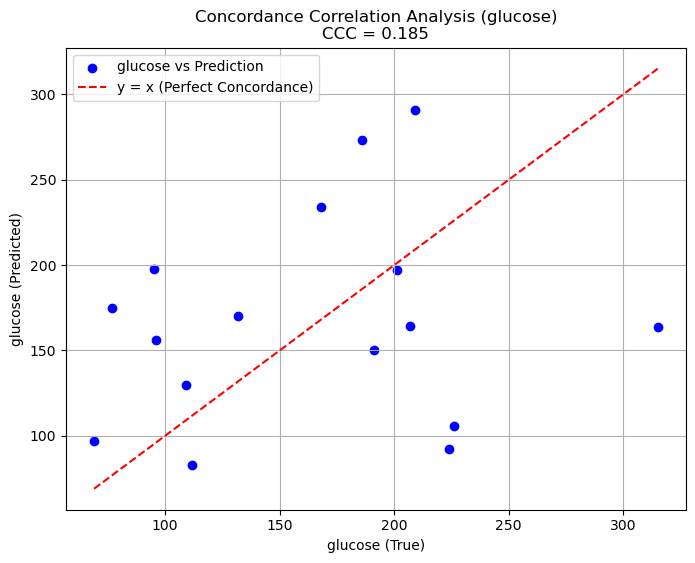

CCC for basal: -0.671


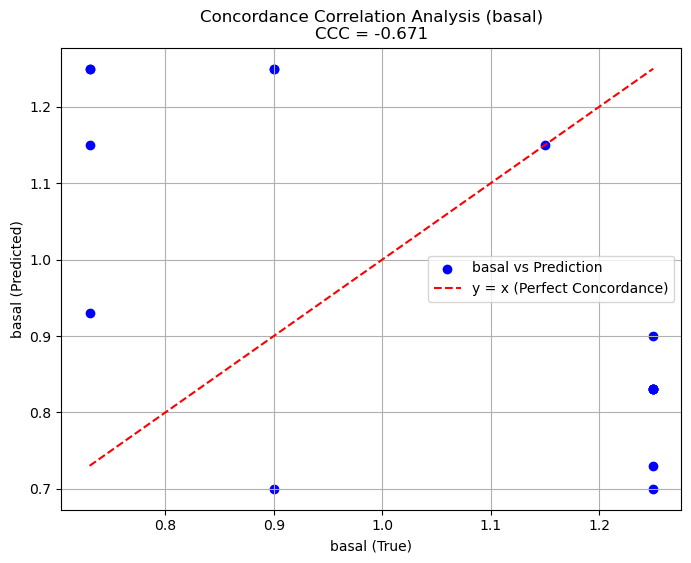

CCC for bolus: 0.219


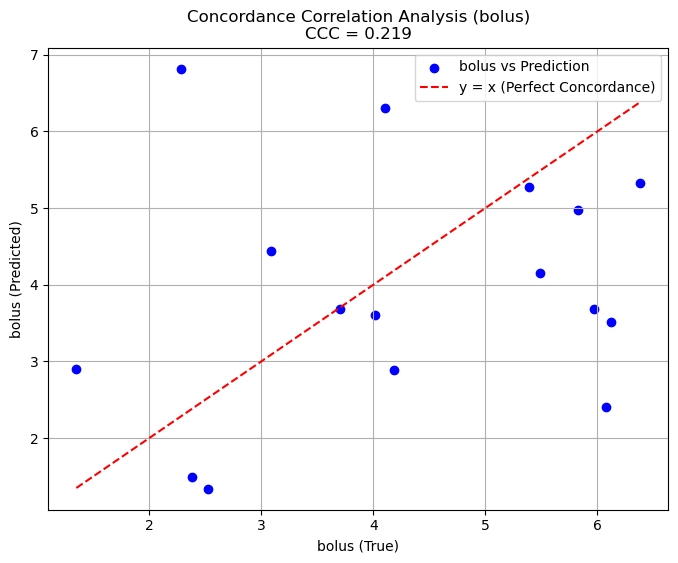

CCC for macc: -0.279


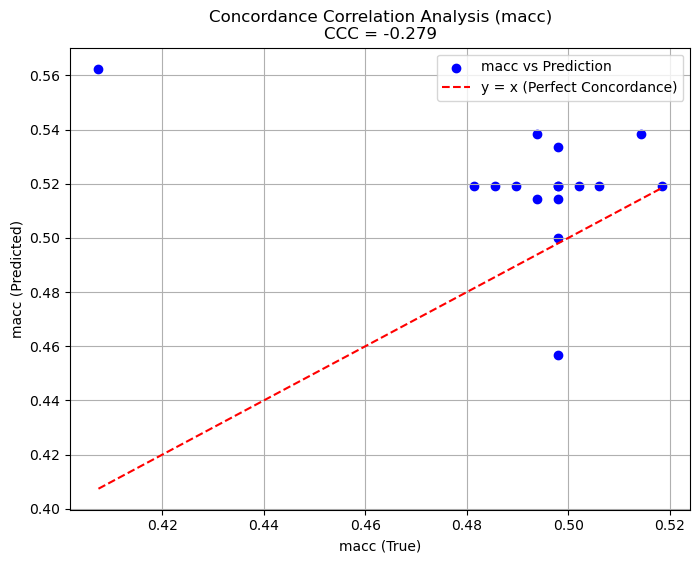

CCC for carbs: -0.118


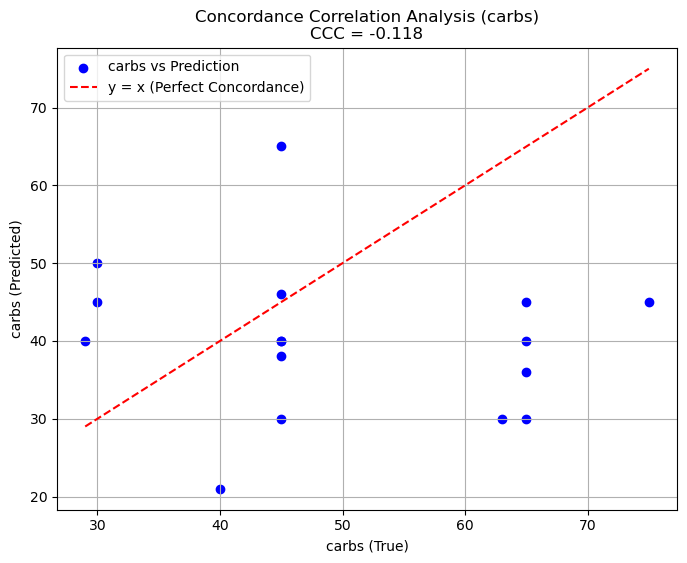

C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: 0.050


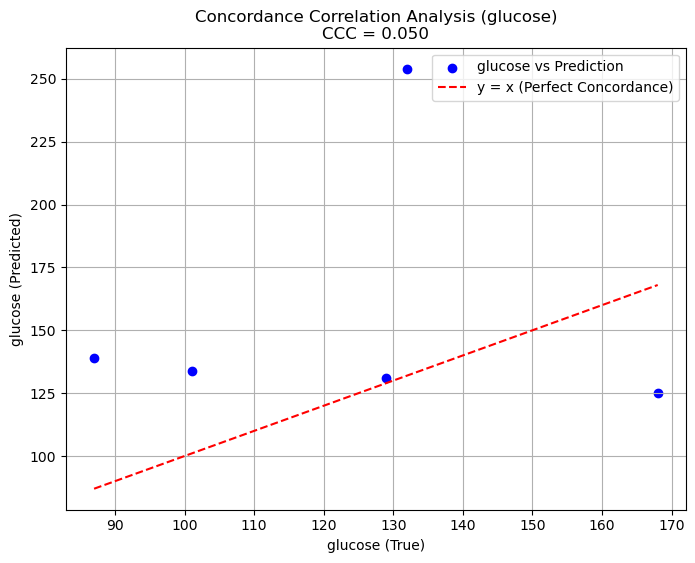

CCC for basal: 0.000


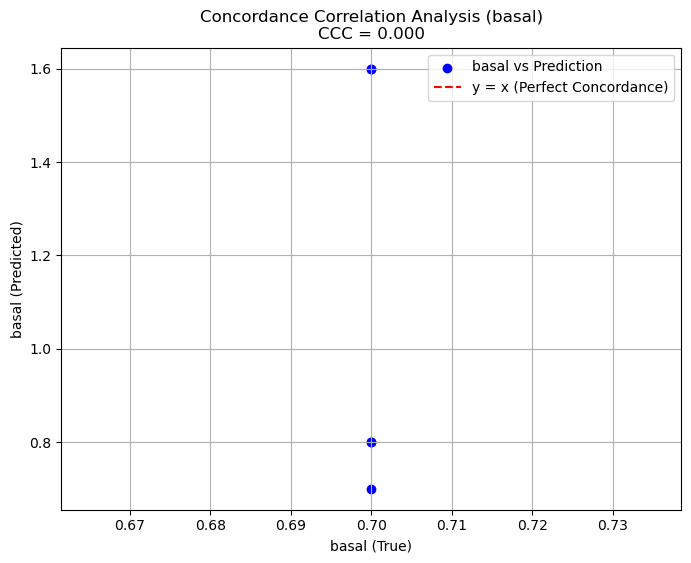

CCC for bolus: 0.136


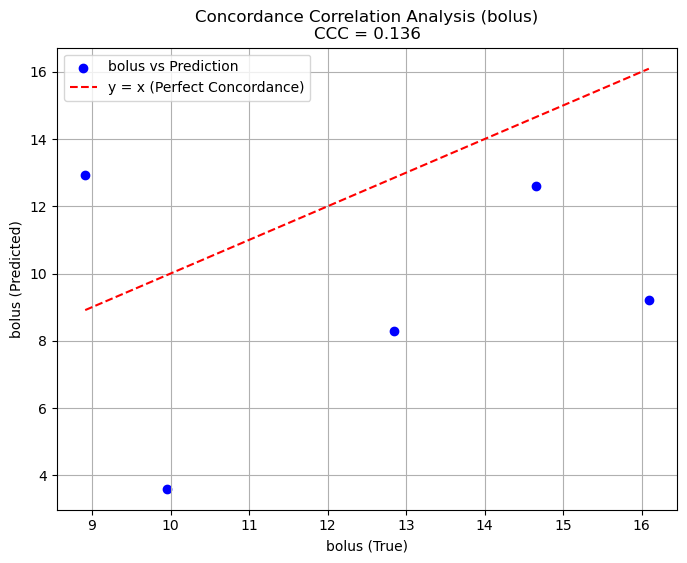

CCC for macc: 0.293


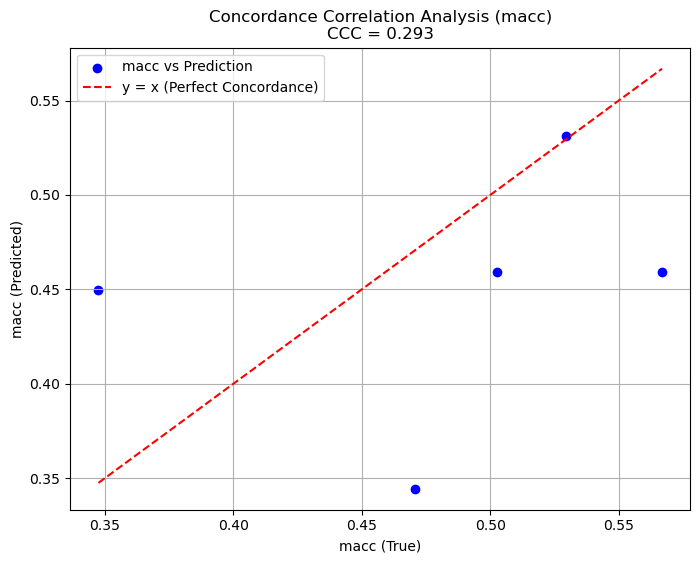

CCC for carbs: 0.354


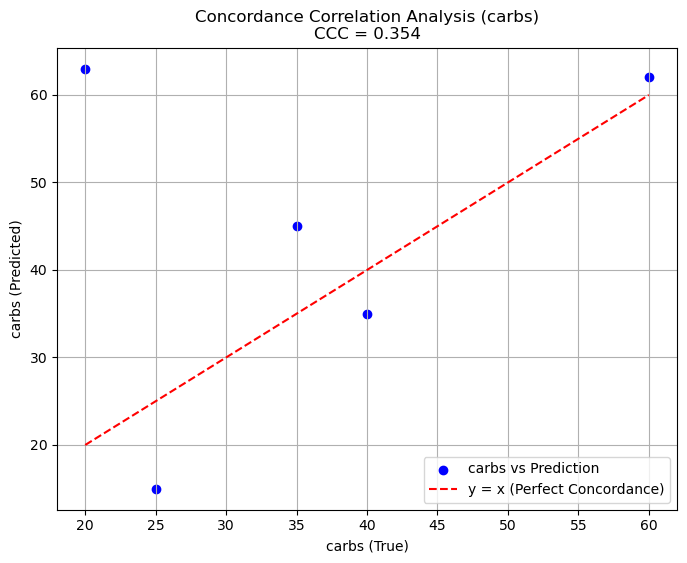

C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: -0.030


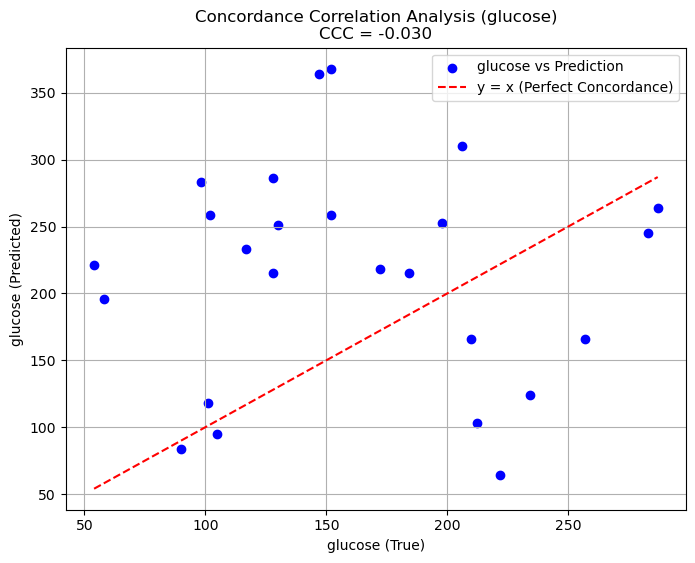

CCC for basal: 0.101


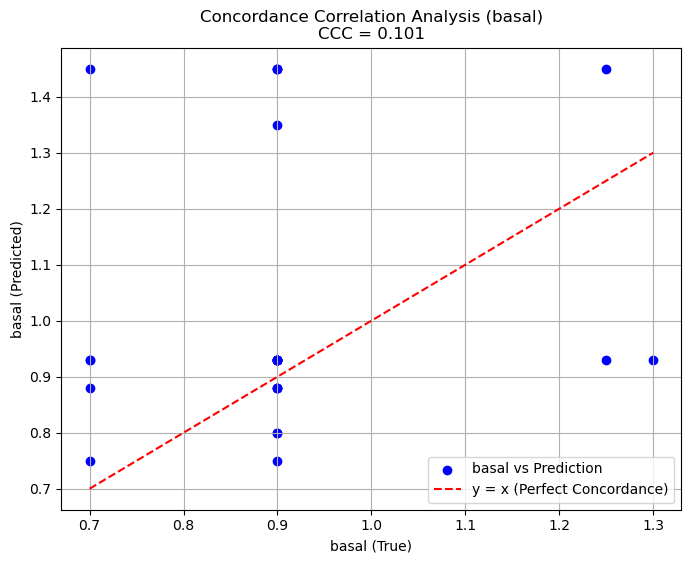

CCC for bolus: -0.220


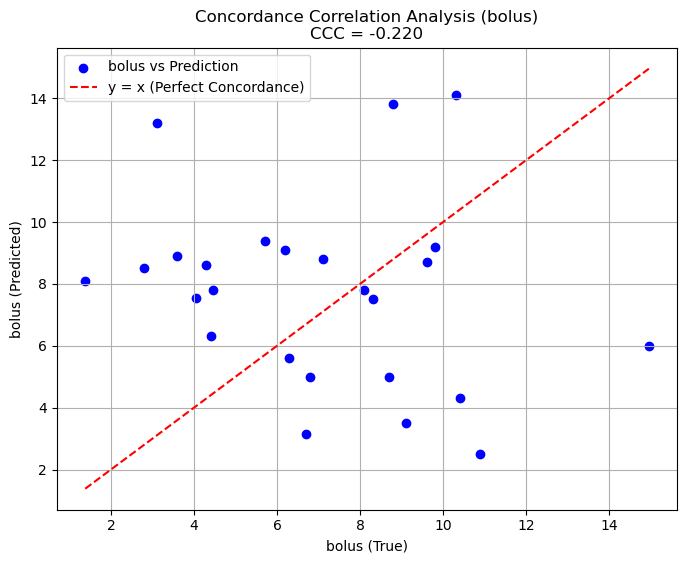

CCC for macc: -0.093


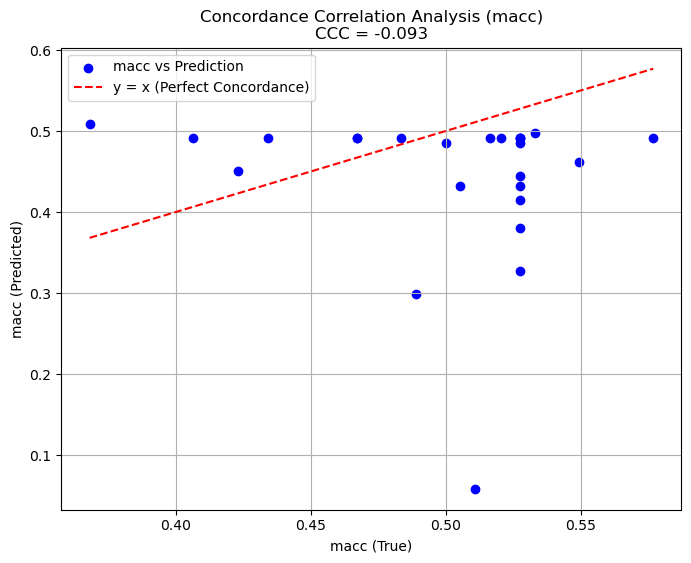

CCC for carbs: -0.080


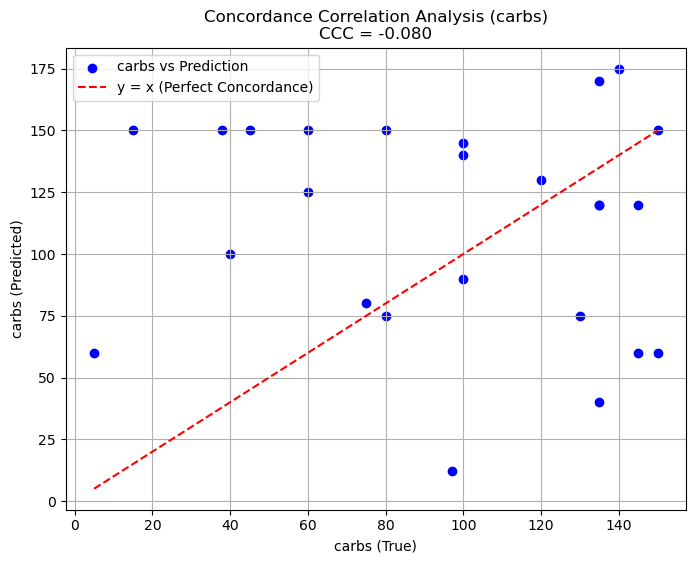

C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: 0.310


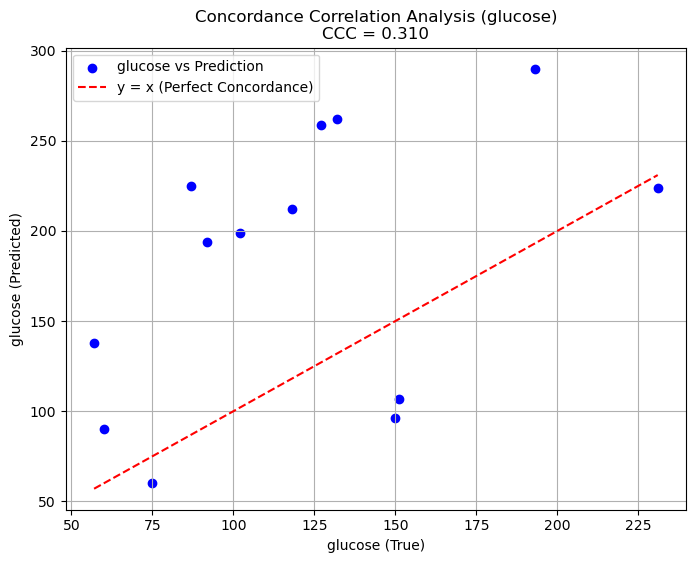

CCC for basal: -0.146


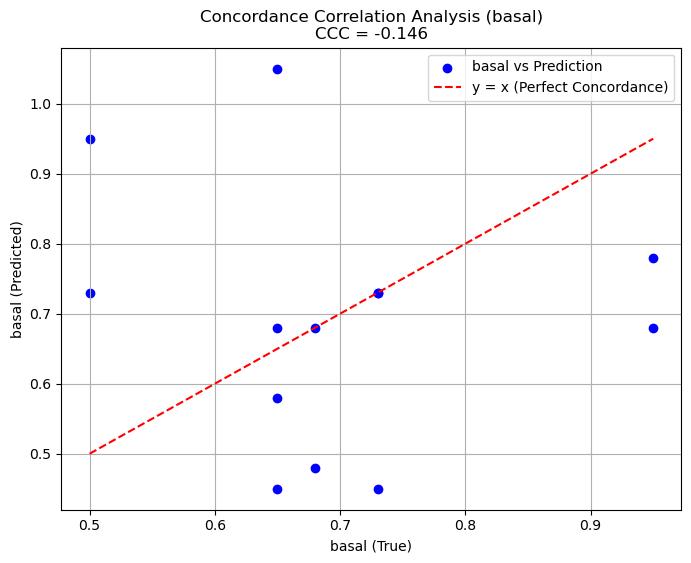

CCC for bolus: 0.232


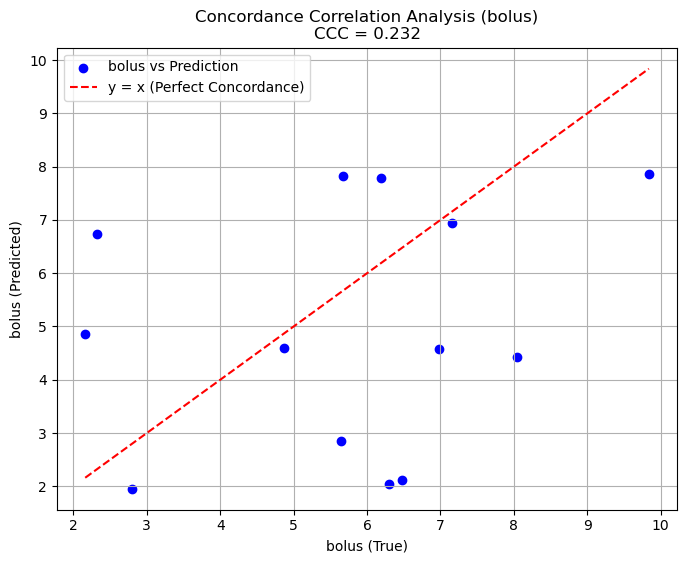

CCC for macc: 0.009


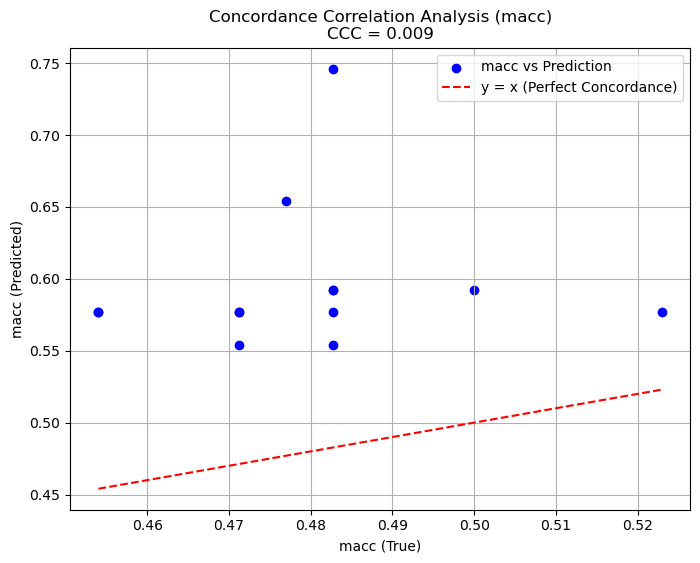

CCC for carbs: 0.301


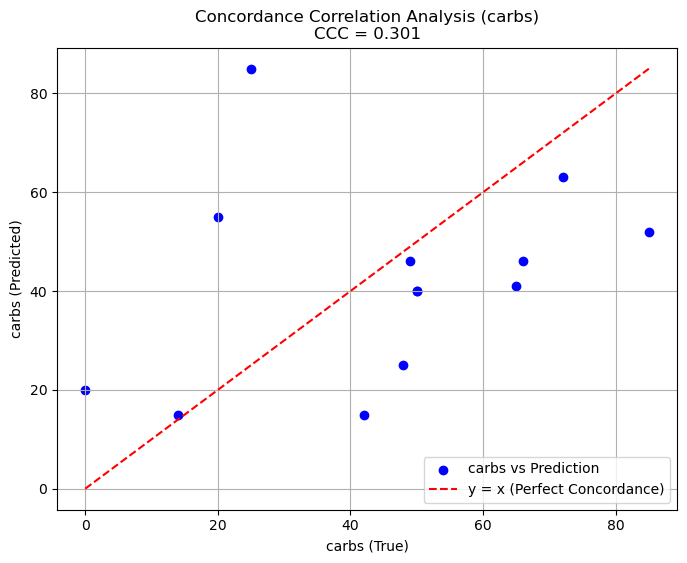

C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: -0.075


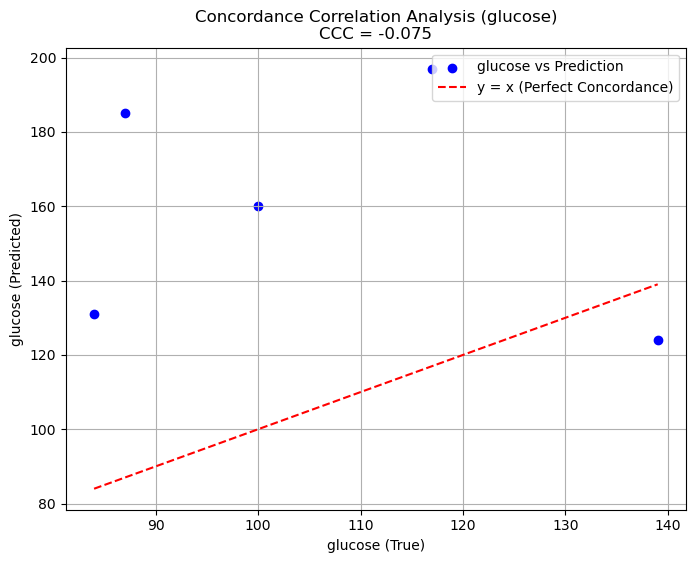

CCC for basal: -0.536


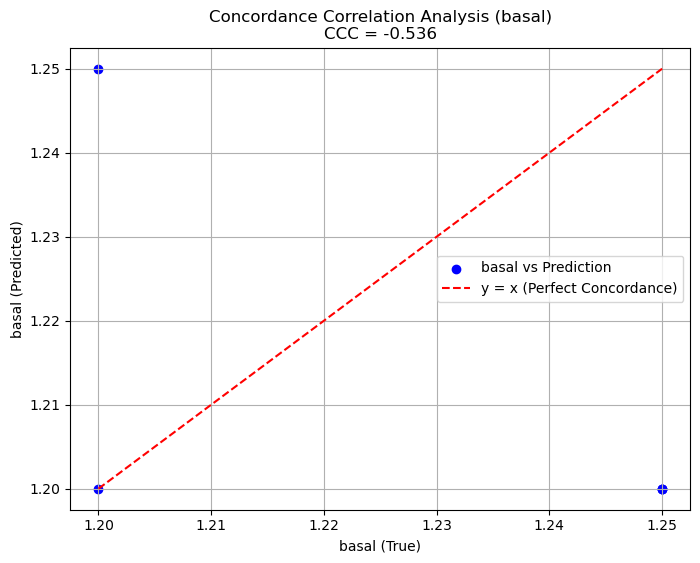

CCC for bolus: -0.403


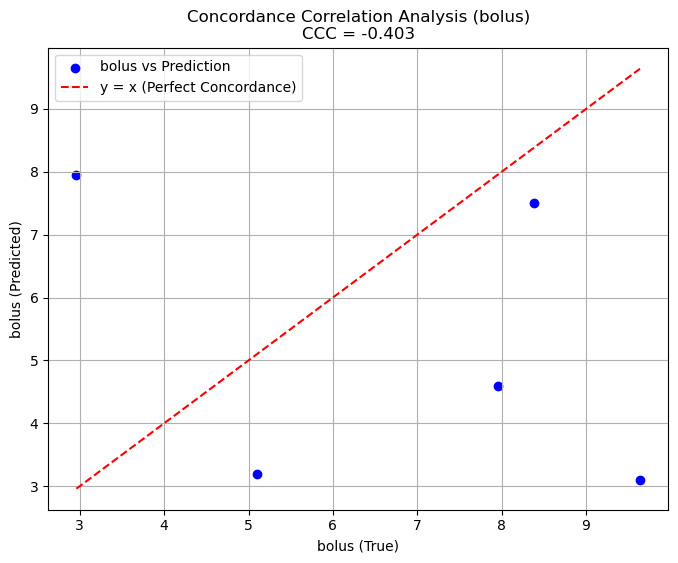

CCC for macc: -0.039


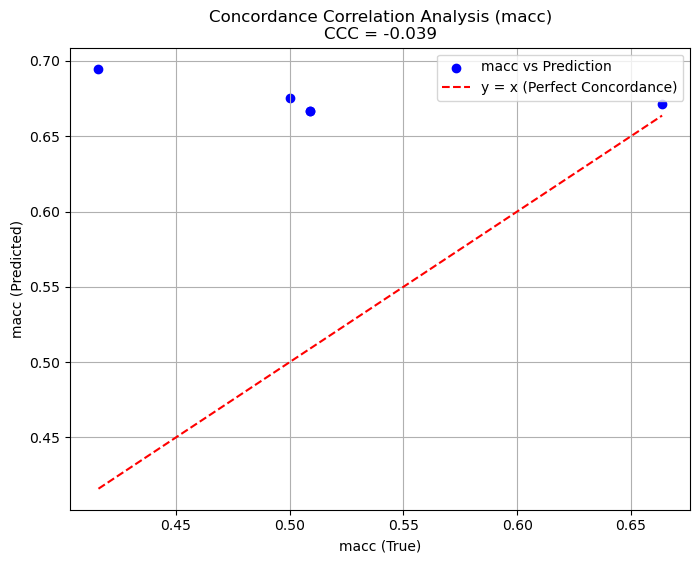

CCC for carbs: -0.967


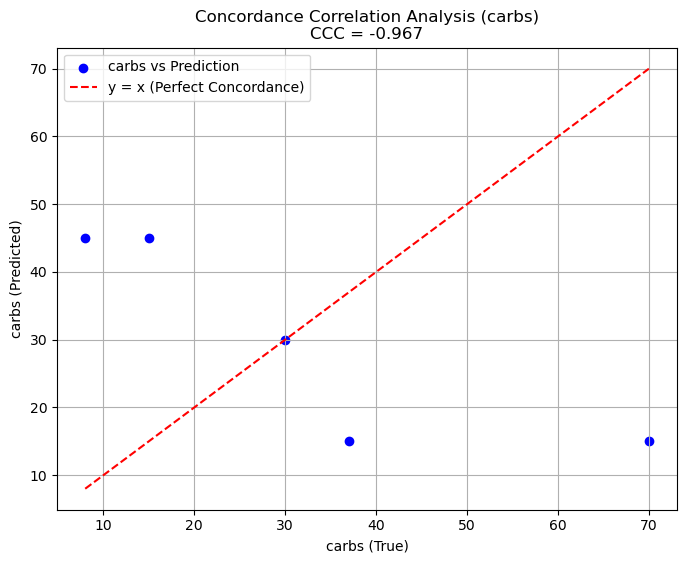

C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: -0.070


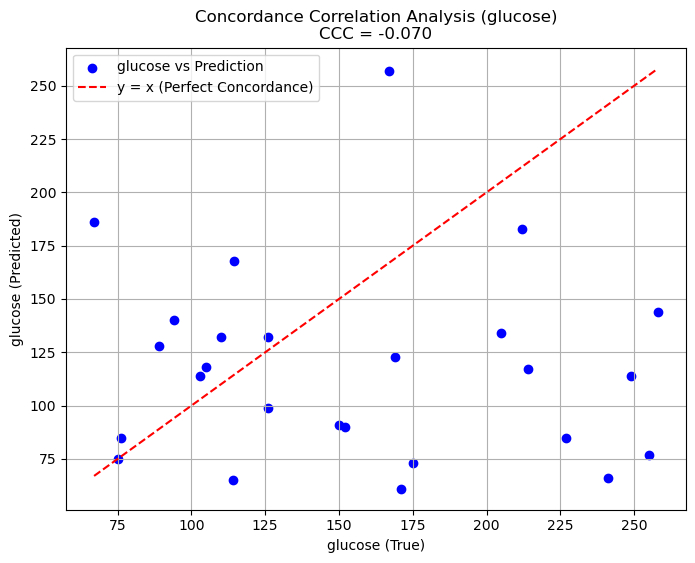

CCC for basal: -0.174


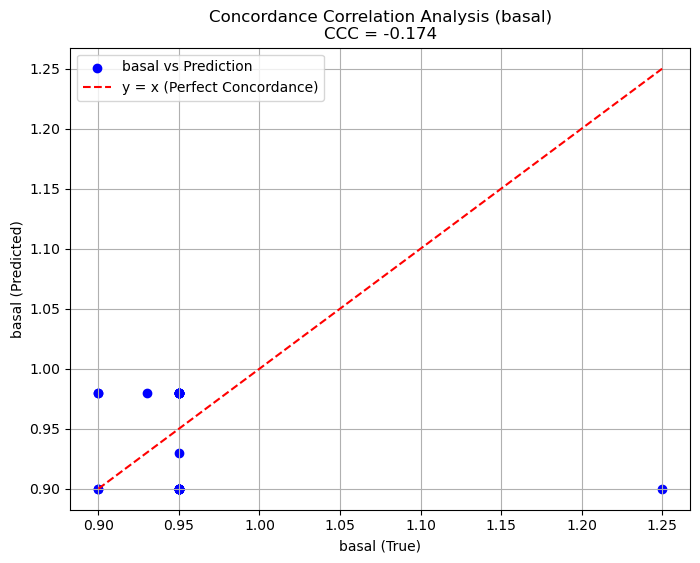

CCC for bolus: -0.120


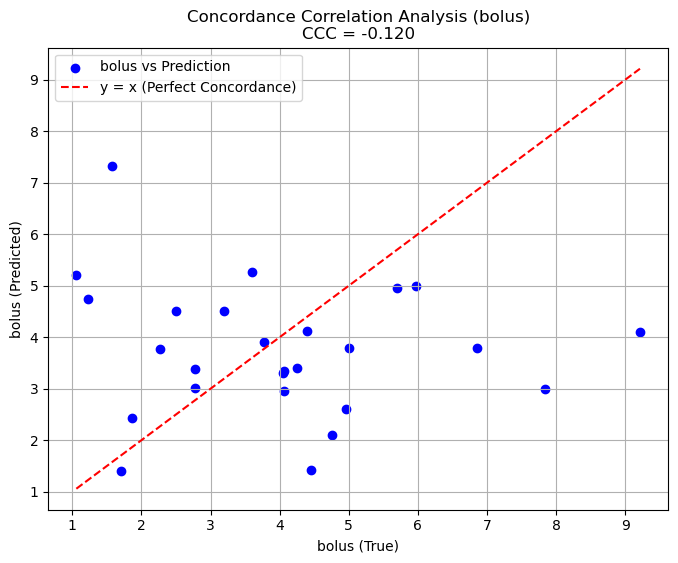

CCC for macc: -0.098


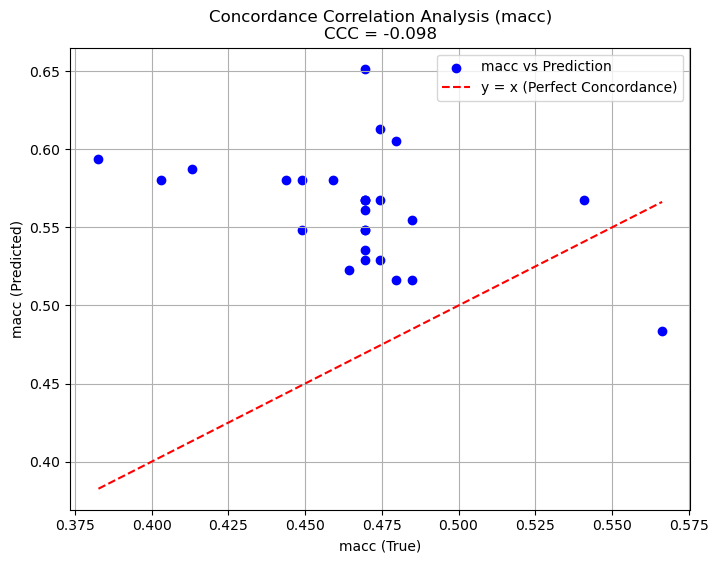

CCC for carbs: 0.077


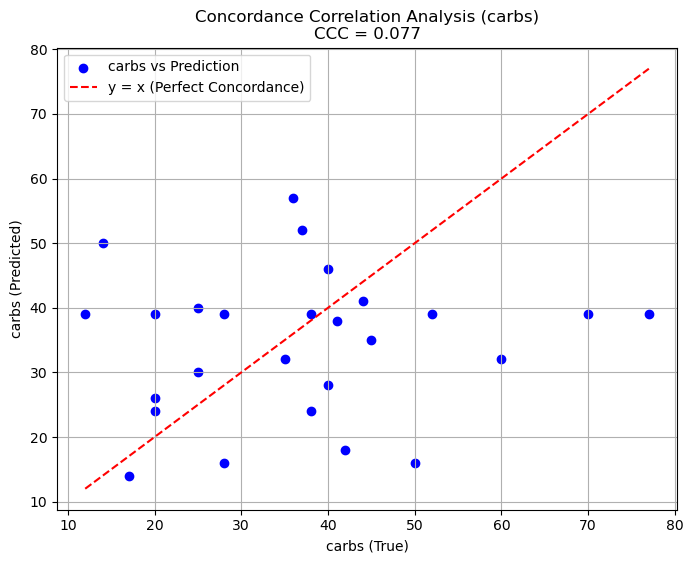


Subject 559 CCC Results:
glucose: 0.185
basal: -0.671
bolus: 0.219
macc: -0.279
carbs: -0.118

Subject 563 CCC Results:
glucose: 0.050
basal: 0.000
bolus: 0.136
macc: 0.293
carbs: 0.354

Subject 570 CCC Results:
glucose: -0.030
basal: 0.101
bolus: -0.220
macc: -0.093
carbs: -0.080

Subject 575 CCC Results:
glucose: 0.310
basal: -0.146
bolus: 0.232
macc: 0.009
carbs: 0.301

Subject 588 CCC Results:
glucose: -0.075
basal: -0.536
bolus: -0.403
macc: -0.039
carbs: -0.967

Subject 591 CCC Results:
glucose: -0.070
basal: -0.174
bolus: -0.120
macc: -0.098
carbs: 0.077


C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: -0.207


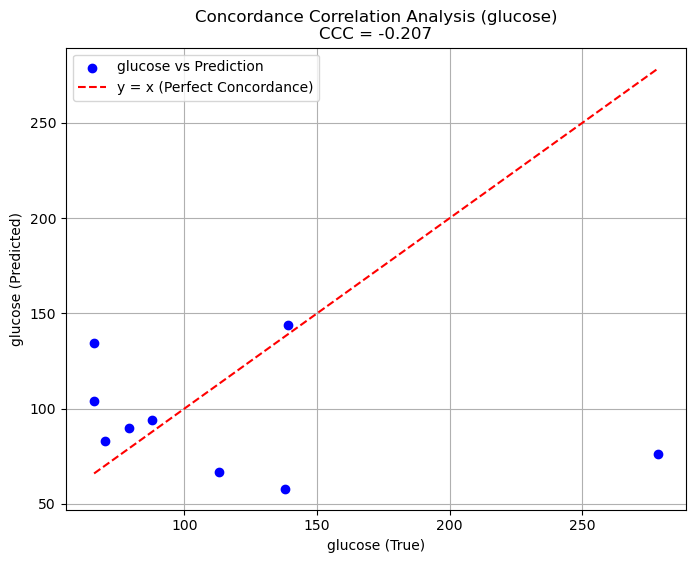

CCC for basal: 0.531


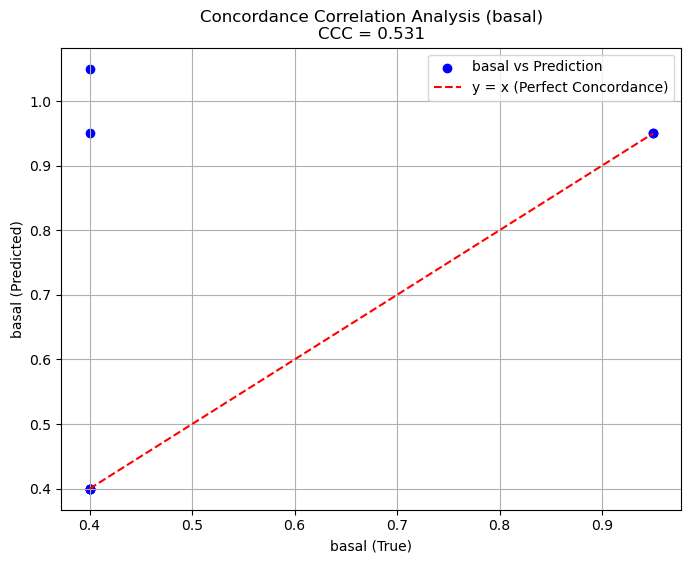

CCC for bolus: -0.236


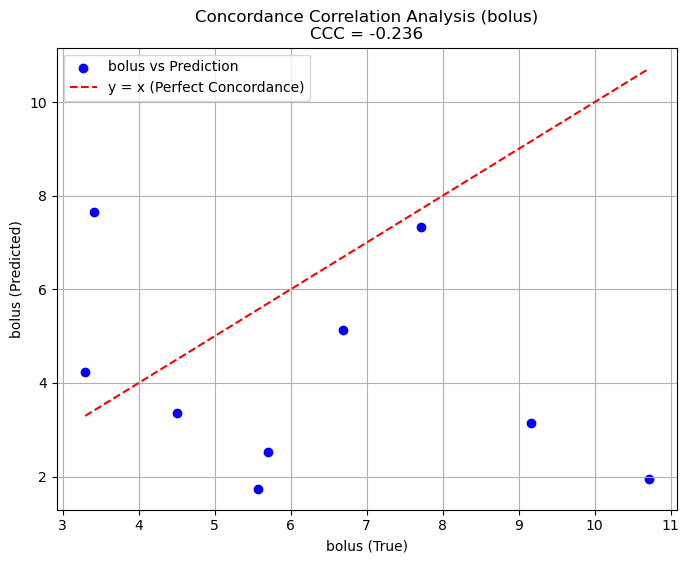

CCC for macc: 0.838


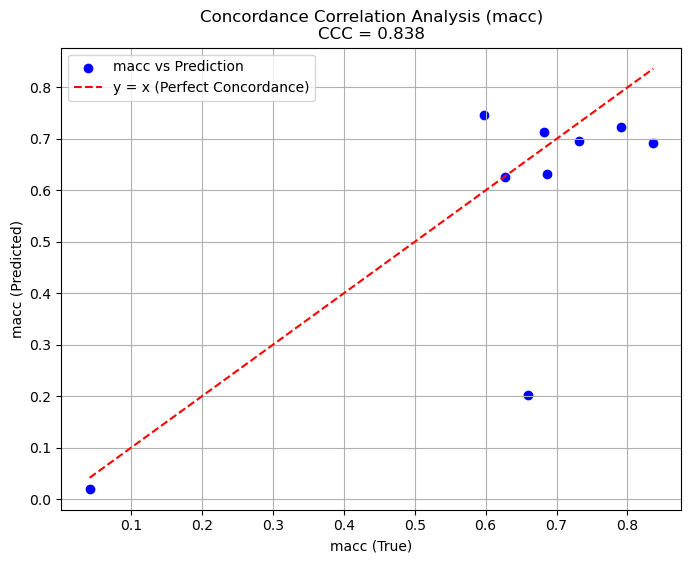

CCC for carbs: -0.276


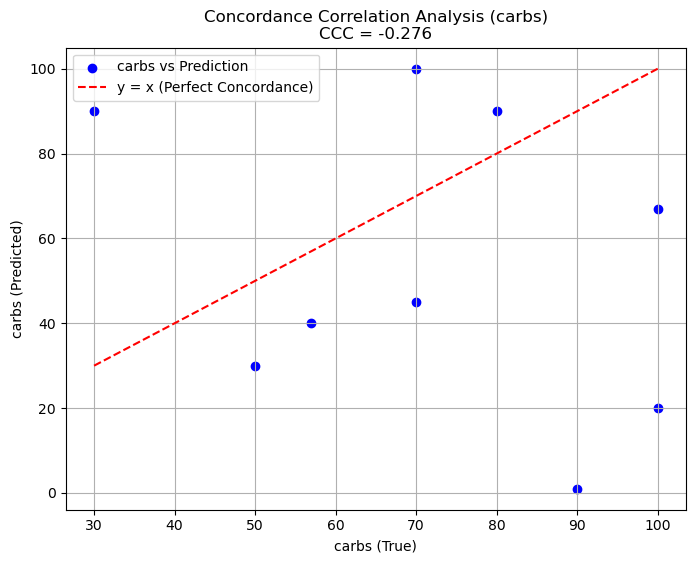

C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: -0.285


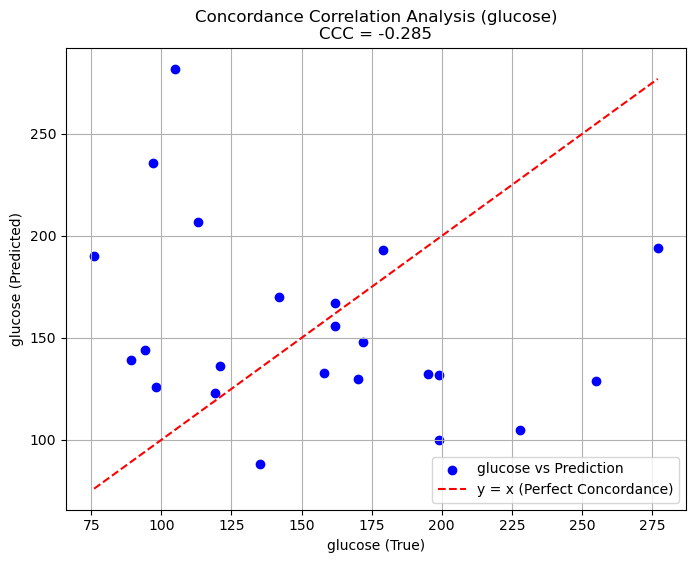

CCC for basal: 0.288


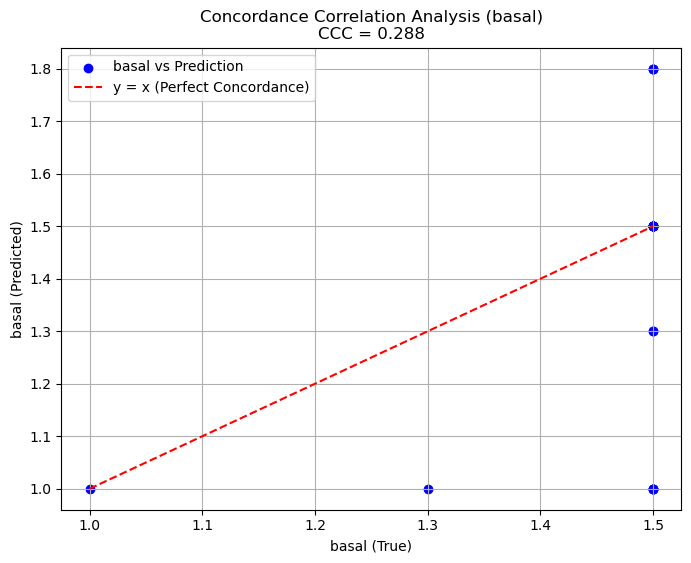

CCC for bolus: 0.205


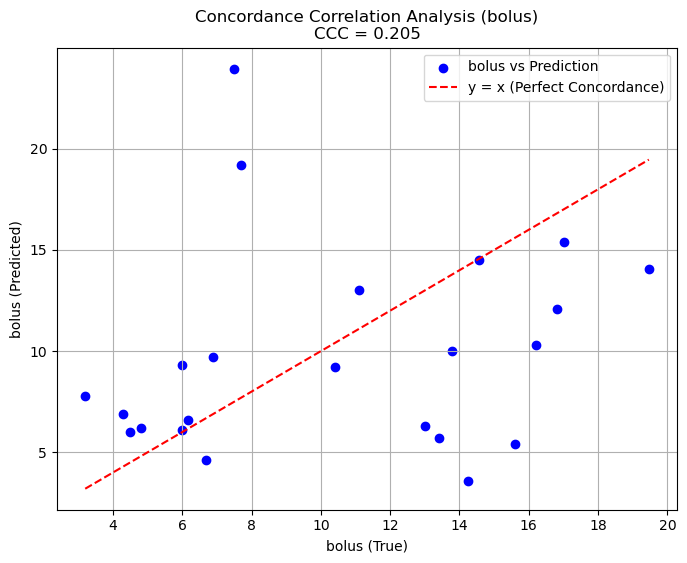

CCC for macc: 0.053


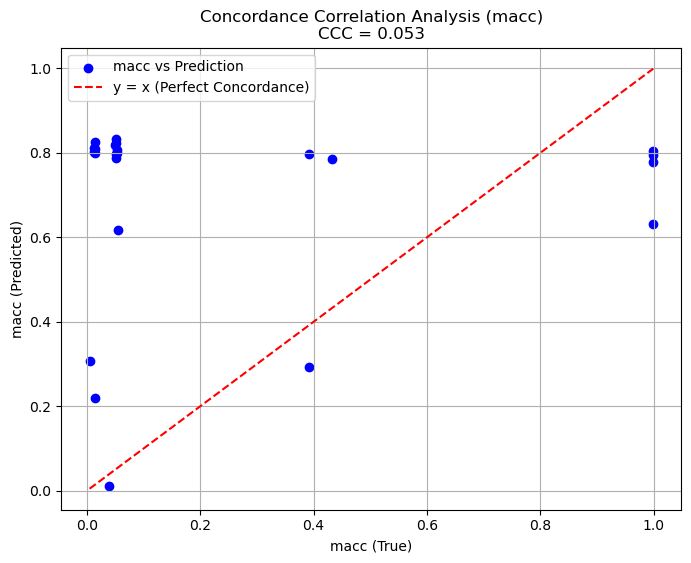

CCC for carbs: 0.239


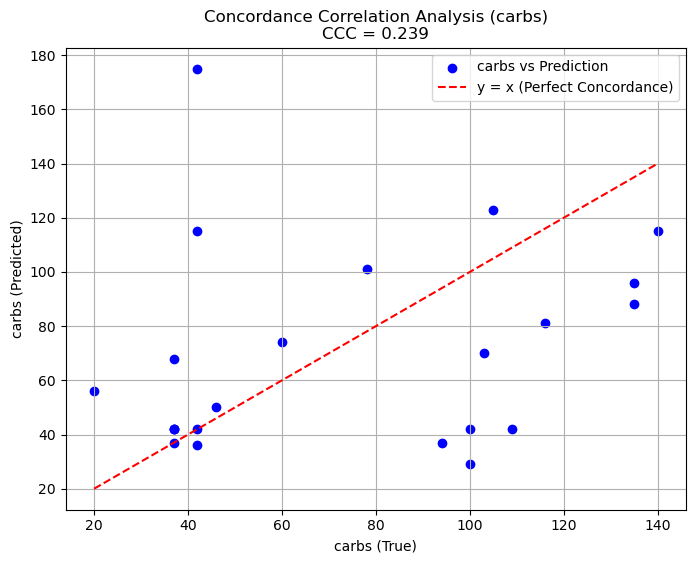

C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: 0.031


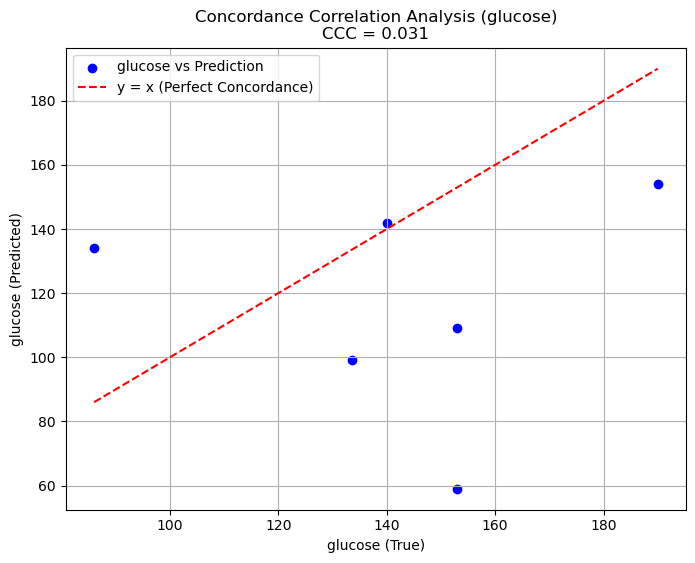

CCC for basal: 0.009


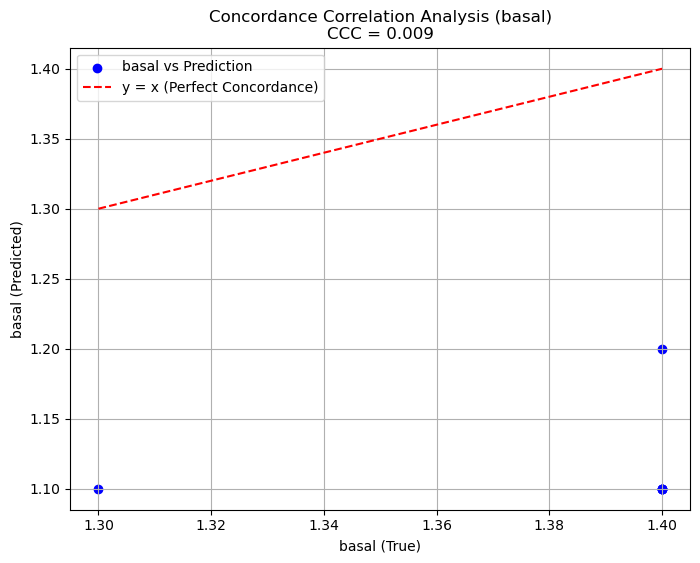

CCC for bolus: 0.753


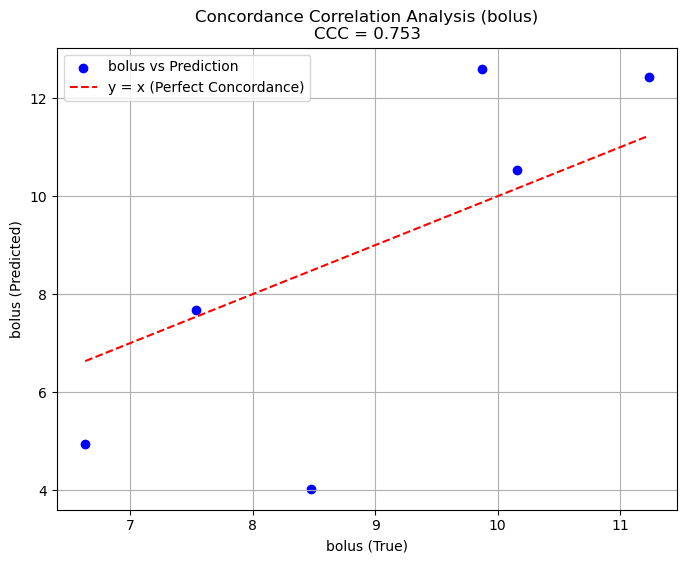

CCC for macc: 0.426


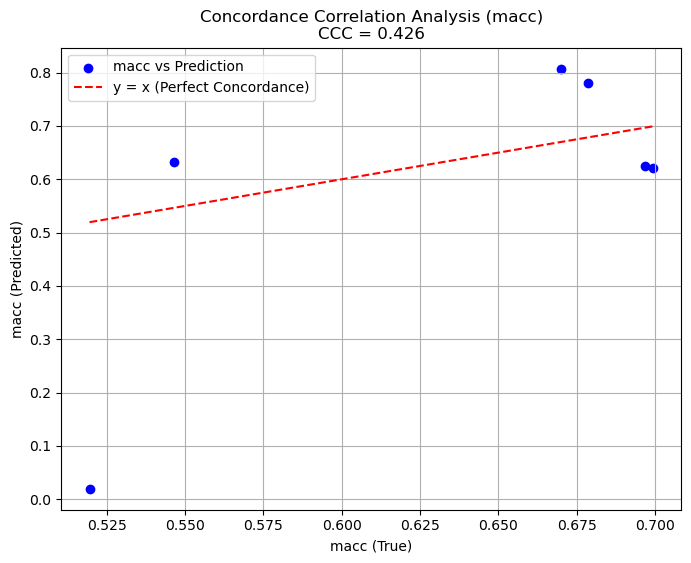

CCC for carbs: 0.830


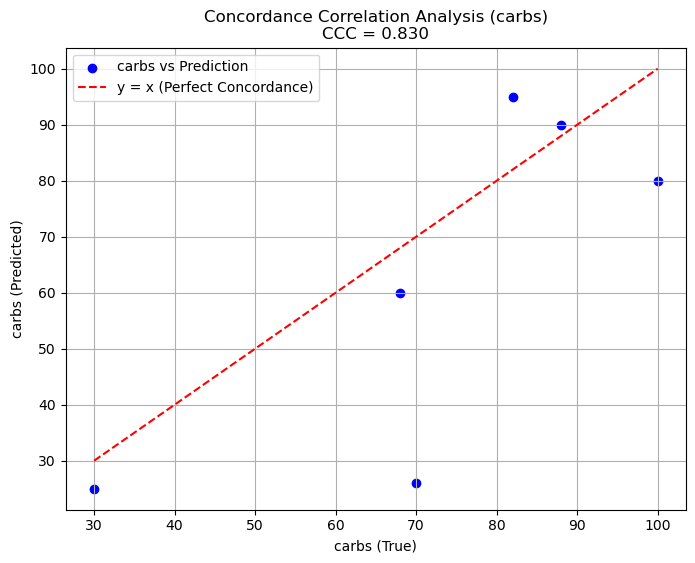

C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")


Skipping subject 567 due to insufficient data.


C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: -0.221


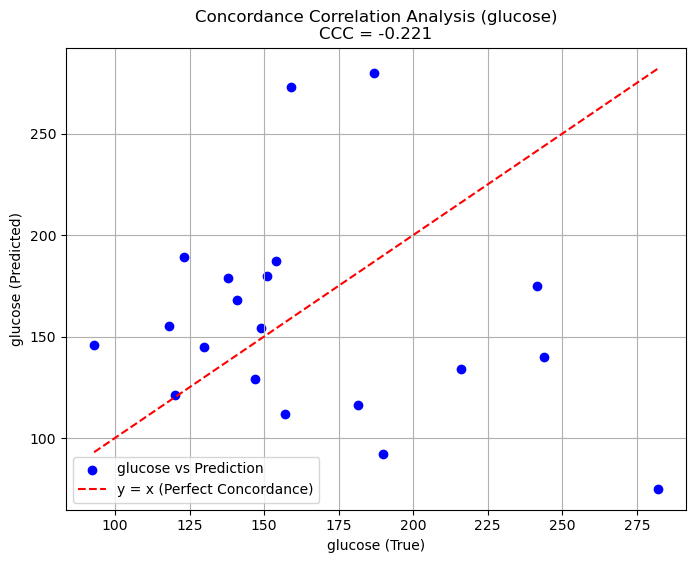

CCC for basal: 0.352


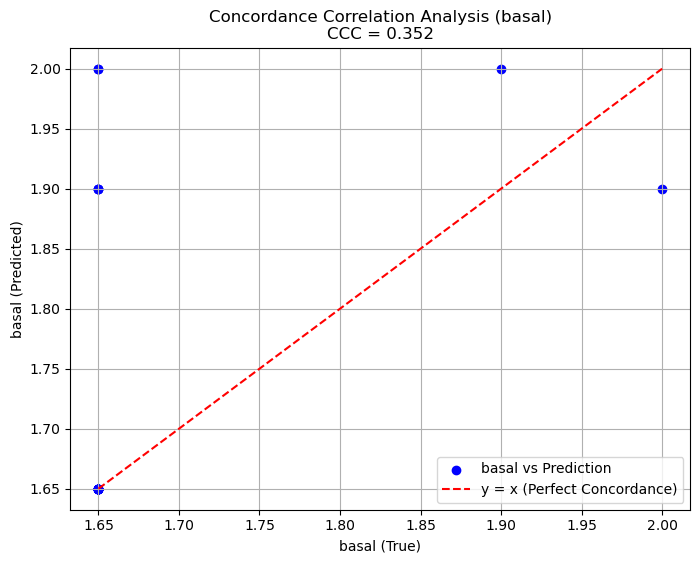

CCC for bolus: 0.039


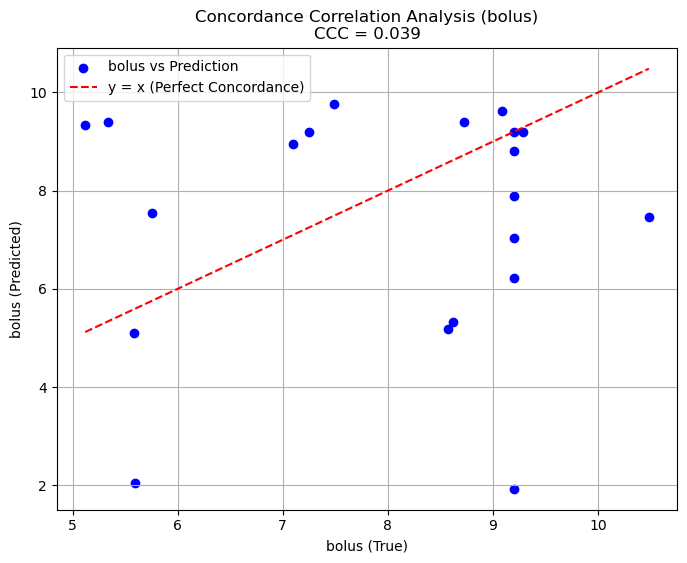

CCC for macc: -0.044


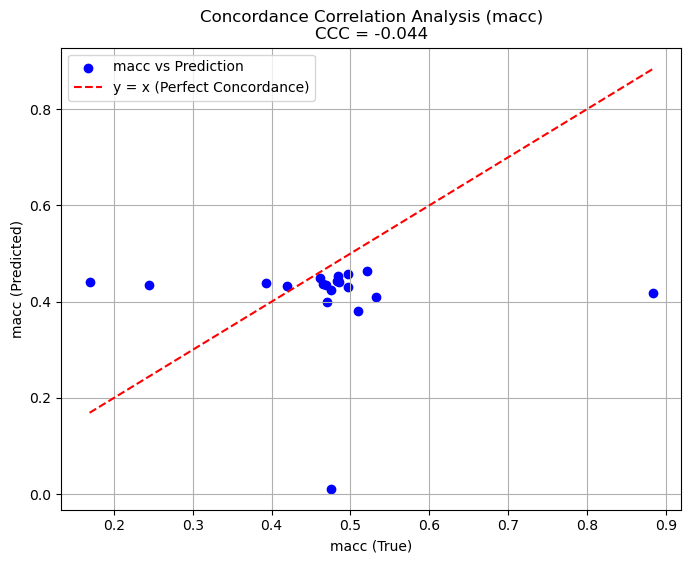

CCC for carbs: -0.021


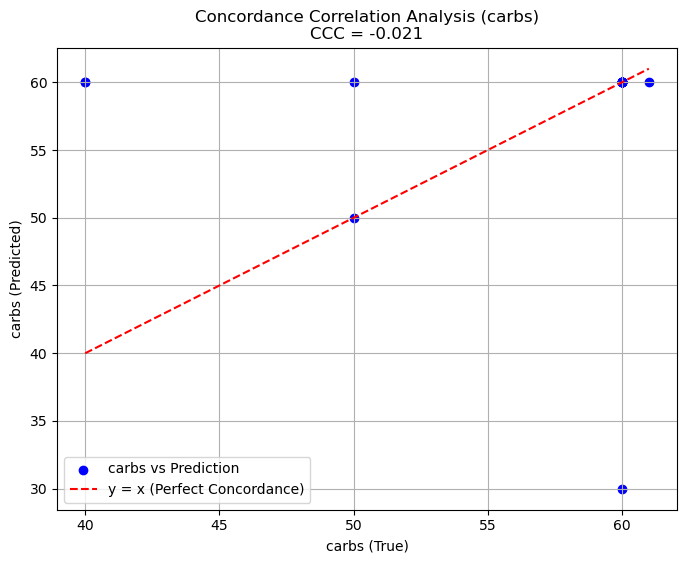

C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:67: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_train = combined_df_train.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_10252\403877721.py:68: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df_test = combined_df_test.interpolate(method="linear", limit=24, limit_direction="both")


CCC for glucose: -0.182


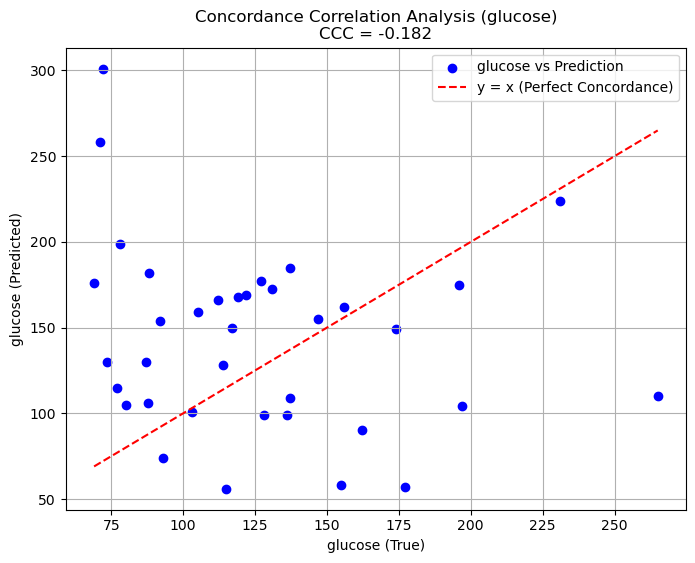

CCC for basal: -0.000


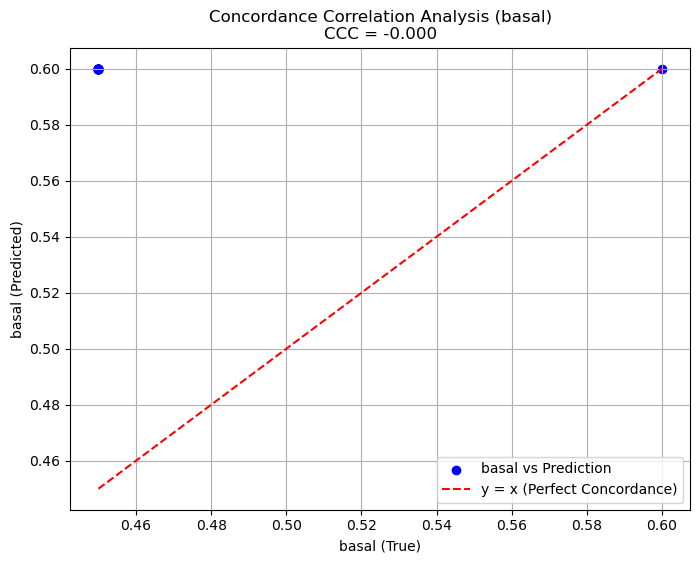

CCC for bolus: -0.122


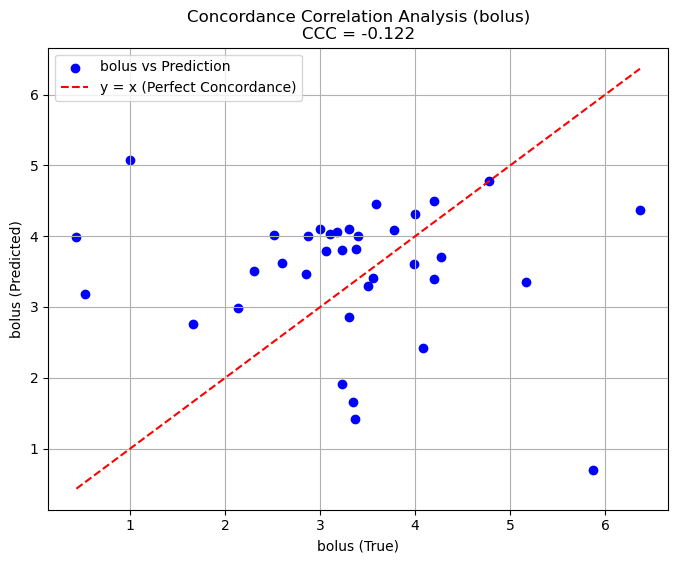

CCC for macc: 0.004


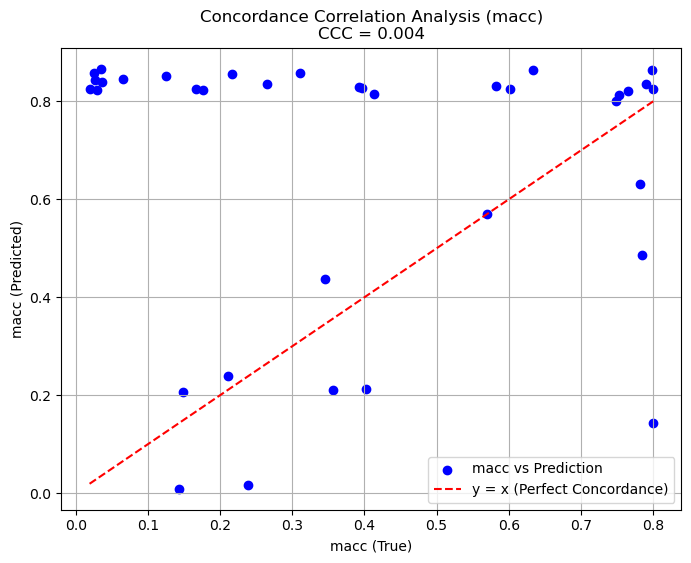

CCC for carbs: 0.450


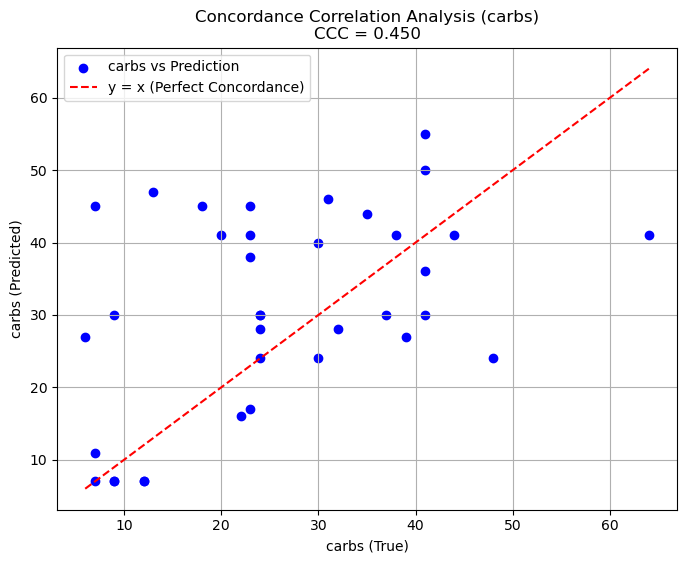


Subject 540 CCC Results:
glucose: -0.207
basal: 0.531
bolus: -0.236
macc: 0.838
carbs: -0.276

Subject 544 CCC Results:
glucose: -0.285
basal: 0.288
bolus: 0.205
macc: 0.053
carbs: 0.239

Subject 552 CCC Results:
glucose: 0.031
basal: 0.009
bolus: 0.753
macc: 0.426
carbs: 0.830

Subject 584 CCC Results:
glucose: -0.221
basal: 0.352
bolus: 0.039
macc: -0.044
carbs: -0.021

Subject 596 CCC Results:
glucose: -0.182
basal: -0.000
bolus: -0.122
macc: 0.004
carbs: 0.450


In [9]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
def main():
    versions_arr = [2018, 2020]

    for v in versions_arr:
        if v == 2018:
            patient_index = [559, 563, 570, 575, 588, 591]
            train_files = ['C:/Praktikum AI Med/OhioT1DM/2018/train/559-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/563-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/570-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/575-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/588-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/591-ws-training.xml'
                        ]


            test_files = ['C:/Praktikum AI Med/OhioT1DM/2018/test/559-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/563-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/570-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/575-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/588-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/591-ws-testing.xml'
                        ]
        elif v == 2020:
            patient_index = [540, 544, 552, 567, 584, 596]
            train_files = ['C:/Praktikum AI Med/OhioT1DM/2020/train/540-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/544-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/552-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/567-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/584-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/596-ws-training.xml'
                        ]


            test_files = ['C:/Praktikum AI Med/OhioT1DM/2020/test/540-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/544-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/552-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/567-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/584-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/596-ws-testing.xml'
                        ]


        data = load_data(train_files, test_files, patient_index, version=v)

        for dataset in data:
            subject_ID = dataset['subject_ID']
            ccc_results = dataset['ccc_results']

            print(f"\nSubject {subject_ID} CCC Results:")
            for feature, ccc_value in ccc_results.items():
                print(f"{feature}: {ccc_value:.3f}")

            output_path = f"GAPS_DATA/RESULTS/{v}/subject_{subject_ID}_ccc_results.csv"
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Convert CCC results to DataFrame and save
            ccc_df = pd.DataFrame(list(ccc_results.items()), columns=['Feature', 'CCC'])
            ccc_df.to_csv(output_path, index=False)

if __name__ == '__main__':
    main()


In [10]:
basal = get_basal(root)
basal

NameError: name 'root' is not defined

In [11]:
glc = get_glc(root)
glc

NameError: name 'root' is not defined

In [12]:
sleep = get_sleep(root)
sleep

NameError: name 'root' is not defined

In [13]:
get_macc = get_macc(root)
get_macc

NameError: name 'root' is not defined

In [14]:
get_meal = get_meal(root)
get_meal

NameError: name 'root' is not defined

hiere is the old version

In [8]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

def load_data(train_files, test_files, patient_index, version):
    count = 0
    data = []

    for i in range(len(train_files)):
        root = ET.parse(train_files[i]).getroot()
        root2 = ET.parse(test_files[i]).getroot()

        subject_ID = patient_index[count]
        count += 1

        # Extract dataframes from XML files
        df_glc = get_glc(root)
        df_basal = get_basal(root)
        df_bolus = get_bolus(root)
        df_temp_basal = get_temp_basal(root)
        df_meal = get_meal(root)

        df_macc = get_step(root) if version == 2018 else get_macc(root)

        # Extract and combine test dataframes similarly
        df_glc2 = get_glc(root2)
        df_basal2 = get_basal(root2)
        df_bolus2 = get_bolus(root2)
        df_temp_basal2 = get_temp_basal(root2)
        df_meal2 = get_meal(root2)

        df_macc2 = get_step(root2) if version == 2018 else get_macc(root2)

        # Combine train dataframes
        combined_df_train = df_glc.copy()
        for df in [df_basal, df_bolus, df_macc, df_meal]:
            if df is not None:
                df = df.reset_index(drop=True)
                combined_df_train = pd.merge(combined_df_train, df, on='ts', how='left')

        # Combine test dataframes
        combined_df_test = df_glc2.copy()
        for df in [df_basal2, df_bolus2, df_macc2, df_meal2]:
            if df is not None:
                combined_df_test = pd.merge(combined_df_test, df, on='ts', how='left')

        # Add Subject_ID column to combined dataframes
        combined_df = combined_df_train.copy()
        combined_df2 = combined_df_test.copy()
        combined_df["Subject_ID"] = subject_ID
        combined_df2["Subject_ID"] = subject_ID

        # Print column names to debug
        print("Columns in combined_df:", combined_df.columns)
        print("Columns in combined_df2:", combined_df2.columns)

        # Convert columns to numeric, coercing errors to NaN
        for col in ['glucose', 'basal', 'bolus', 'macc', 'carbs']:
            if col in combined_df.columns:
                combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
            if col in combined_df2.columns:
                combined_df2[col] = pd.to_numeric(combined_df2[col], errors='coerce')

        # Ensure columns with object dtype are inferred correctly before interpolation
        combined_df = combined_df.infer_objects(copy=False)
        combined_df2 = combined_df2.infer_objects(copy=False)


        # Linear interpolation for both dataframes

        combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
        combined_df2 = combined_df2.interpolate(method="linear", limit=24, limit_direction="both")

        # Ensure no NaNs remain after interpolation
        combined_df = combined_df.dropna()
        combined_df2 = combined_df2.dropna()

        # Create Class column
        combined_df["Class"] = -1
        combined_df.loc[combined_df["glucose"] <= 70, "Class"] = 0
        combined_df.loc[(combined_df["glucose"] > 70) & (combined_df["Class"] == -1), "Class"] = 1

        combined_df2["Class"] = -1
        combined_df2.loc[combined_df2["glucose"] <= 70, "Class"] = 0
        combined_df2.loc[(combined_df2["glucose"] > 70) & (combined_df2["Class"] == -1), "Class"] = 1

        # Print class distribution
        print(np.bincount(combined_df["Class"]))
        print(len(combined_df))

        print(np.bincount(combined_df2["Class"]))
        print(len(combined_df2))

        # Prepare feature set
        features = combined_df[['glucose', 'basal', 'bolus', 'macc', 'carbs']]
        features2 = combined_df2[['glucose', 'basal', 'bolus', 'macc', 'carbs']]

        # Ensure no NaNs remain
        features = features.fillna(0)
        features2 = features2.fillna(0)

        # Scale features
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        scaled_features2 = scaler.transform(features2)

        # Initialize and fit the model
        model = OneClassSVM()
        model.fit(scaled_features)

        # Predict anomalies
        predictions = model.predict(scaled_features2)

        # Add predictions to combined_df2
        combined_df2['Prediction'] = np.nan
        combined_df2.loc[combined_df2.index.isin(np.where(predictions == -1)[0]), 'Prediction'] = -1
        combined_df2.loc[combined_df2.index.isin(np.where(predictions != -1)[0]), 'Prediction'] = 1

        # Print shapes
        print("Features before scaling:")
        print(features.head())
        print("Shape before scaling:", features.shape)
        print("Features after scaling:")
        print(pd.DataFrame(scaled_features).head())
        print("Shape after scaling:", scaled_features.shape)
        print("Shape of predictions:", predictions.shape)
        print("Shape of combined_df2 with predictions:", combined_df2.shape)

        # Append processed data for One-Class SVM
        data.append({
            'glucose': combined_df[['ts', 'glucose']],
            'basal': combined_df[['ts', 'basal']],
            'bolus': combined_df[['ts', 'bolus']],
            'macc': combined_df[['ts', 'macc']],
            'carbs': combined_df[['ts', 'carbs']],
            'prediction': combined_df2[['ts', 'Prediction']]
        })

    return data

In [9]:
from sklearn.svm import OneClassSVM

def train_svm(features):
    model = OneClassSVM(gamma='auto').fit(features)
    return model

def predict_svm(model, features_test):
    predictions = model.predict(features_test)
    return predictions

In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

def main():
    versions_arr = [2018, 2020]

    for v in versions_arr:
        if v == 2018:
            patient_index = [559, 563, 570, 575, 588, 591]
            train_files = ['C:/Praktikum AI Med/OhioT1DM/2018/train/559-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/563-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/570-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/575-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/588-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/train/591-ws-training.xml'
                        ]


            test_files = ['C:/Praktikum AI Med/OhioT1DM/2018/test/559-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/563-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/570-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/575-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/588-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2018/test/591-ws-testing.xml'
            ]
        elif v == 2020:
            patient_index = [540, 544, 552, 567, 584, 596]
            train_files = ['C:/Praktikum AI Med/OhioT1DM/2020/train/540-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/544-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/552-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/567-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/584-ws-training.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/train/596-ws-training.xml'
                        ]


            test_files = ['C:/Praktikum AI Med/OhioT1DM/2020/test/540-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/544-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/552-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/567-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/584-ws-testing.xml',
                        'C:/Praktikum AI Med/OhioT1DM/2020/test/596-ws-testing.xml'
                        ]

        data = load_data(train_files, test_files, patient_index, version=v)

        for dataset in data:
            features = dataset['features']
            features_test = dataset['features_test']
            combined_df_test = dataset['combined_df_test']
            subject_ID = dataset['subject_ID']

            # Train One-Class SVM
            model = OneClassSVM(gamma='auto')
            model.fit(features)

            # Predict anomalies
            predictions = model.predict(features_test)

            # Add predictions to combined_df_test
            combined_df_test['Prediction'] = np.nan
            combined_df_test.loc[combined_df_test.index.isin(np.where(predictions == -1)[0]), 'Prediction'] = -1
            combined_df_test.loc[combined_df_test.index.isin(np.where(predictions != -1)[0]), 'Prediction'] = 1

            # Print shapes
            print("Shape of predictions:", predictions.shape)
            print("Shape of combined_df_test with predictions:", combined_df_test.shape)

            # Save the results
            output_path = f"GAPS_DATA/RESULTS/{v}/subject_{subject_ID}.csv"
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            combined_df_test.to_csv(output_path, index=False)

if __name__ == '__main__':
    main()


Columns in combined_df: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
Columns in combined_df2: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
[  4 105]
109
[ 0 16]
16
Features before scaling:
     glucose  basal     bolus      macc  carbs
335    209.0   0.73  4.100000  0.493827   45.0
404    191.0   1.15  6.124000  0.407407   63.0
498     96.0   1.25  2.378261  0.489712   30.0
706     69.0   1.25  2.522034  0.497942   45.0
735    207.0   1.25  3.704545  0.518519   45.0
Shape before scaling: (109, 5)
Features after scaling:
          0         1         2         3         4
0  0.827287 -1.363167  0.112059 -0.089128  0.431370
1  0.536792  0.681583  1.411948 -3.870832  1.593938
2 -0.996379  1.168429 -0.993707 -0.269209 -0.537435
3 -1.432122  1.168429 -0.901370  0.090954  0.431370
4  0.795010  1.168429 -0.141917  0.991359  0.431370
Shap

C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:74: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:75: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df2 = combined_df2.interpolate(method="linear", limit=24, limit_direction="both")


Columns in combined_df: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
Columns in combined_df2: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
[ 3 93]
96
[0 5]
5
Features before scaling:
      glucose  basal      bolus      macc  carbs
1145     87.0    0.7   9.950000  0.529412   25.0
1157    101.0    0.7   8.913333  0.470588   20.0
1247    132.0    0.7  16.092000  0.502674   40.0
1392    168.0    0.7  12.840000  0.566845   35.0
1485    129.0    0.7  14.653684  0.347594   60.0
Shape before scaling: (96, 5)
Features after scaling:
          0         1         2         3         4
0 -1.182465 -0.471469  0.390816  0.503255 -0.221103
1 -0.867717 -0.471469  0.129147 -0.123644 -0.549677
2 -0.170777 -0.471469  1.941142  0.218301  0.764620
3  0.638573 -0.471469  1.120292  0.902191  0.436045
4 -0.238223 -0.471469  1.578091 -1.434434  2.078917

C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:74: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:75: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df2 = combined_df2.interpolate(method="linear", limit=24, limit_direction="both")


Columns in combined_df: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
Columns in combined_df2: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
[  5 128]
133
[ 1 24]
25
Features before scaling:
     glucose  basal  bolus      macc  carbs
61     147.0   0.90   1.38  0.527473    5.0
165    152.0   1.25   6.70  0.434066   97.0
235    198.0   0.70   9.60  0.368132  120.0
292    234.0   0.70   3.10  0.467033   38.0
323    172.0   0.90  10.40  0.527473  150.0
Shape before scaling: (133, 5)
Features after scaling:
          0         1         2         3         4
0 -0.529470 -0.127605 -1.791433  0.441886 -2.361617
1 -0.448444  1.711409 -0.083594 -0.626389 -0.131069
2  0.296990 -1.178470  0.847372 -1.380464  0.426568
3  0.880373 -1.178470 -1.239275 -0.249351 -1.561530
4 -0.124342 -0.127605  1.104190  0.441886  1.153920
Shape after scaling: (

C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:74: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:75: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df2 = combined_df2.interpolate(method="linear", limit=24, limit_direction="both")


Columns in combined_df: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
Columns in combined_df2: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
[ 31 157]
188
[ 1 12]
13
Features before scaling:
     glucose  basal     bolus      macc  carbs
27     102.0   0.50  4.865517  0.454023   50.0
72     118.0   0.65  2.314286  0.454023   25.0
83      87.0   0.65  2.802632  0.471264   14.0
230    231.0   0.68  6.980822  0.482759   50.0
283     60.0   0.95  6.472603  0.471264    0.0
Shape before scaling: (188, 5)
Features after scaling:
          0         1         2         3         4
0 -0.392810 -2.194838 -0.334427 -0.393997  0.242616
1 -0.118296 -0.795461 -1.475366 -0.393997 -0.910363
2 -0.650167 -0.795461 -1.256972 -0.100366 -1.417675
3  1.820460 -0.515586  0.611561  0.095388  0.242616
4 -1.113410  2.003292  0.384280 -0.100366 -2.063343
Shap

C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:74: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:75: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df2 = combined_df2.interpolate(method="linear", limit=24, limit_direction="both")


Columns in combined_df: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
Columns in combined_df2: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
[  7 156]
163
[0 5]
5
Features before scaling:
     glucose  basal     bolus      macc  carbs
1      117.0   1.20  5.100000  0.663717   37.0
57     100.0   1.25  8.385714  0.508850    8.0
78      87.0   1.25  9.640260  0.415929   70.0
101     84.0   1.25  7.951786  0.500000   30.0
229    139.0   1.20  2.959091  0.508850   15.0
Shape before scaling: (163, 5)
Features after scaling:
          0         1         2         3         4
0 -0.656680 -1.504606  0.205059  3.415974  0.252835
1 -0.980482  0.473223  1.745411  0.129742 -1.497022
2 -1.228095  0.473223  2.333546 -1.841998  2.244052
3 -1.285237  0.473223  1.541985 -0.058043 -0.169544
4 -0.237643 -1.504606 -0.798605  0.129742 -1.074643
Shape a

C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:74: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:75: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df2 = combined_df2.interpolate(method="linear", limit=24, limit_direction="both")


Columns in combined_df: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
Columns in combined_df2: Index(['ts', 'glucose', 'basal', 'bolus', 'bolus_end', 'macc', 'carbs', 'type',
       'Subject_ID'],
      dtype='object')
[ 18 151]
169
[ 3 23]
26
Features before scaling:
     glucose  basal     bolus      macc  carbs
26     227.0   0.95  7.835294  0.469388   60.0
45     169.0   0.95  1.858333  0.469388   20.0
161    114.0   1.25  5.000000  0.448980   52.0
216    126.0   0.90  1.566667  0.413265   14.0
233    152.0   0.90  4.400000  0.448980   44.0
Shape before scaling: (169, 5)
Features after scaling:
          0         1         2         3         4
0  1.495229 -0.232286  2.531751  0.165146  1.942493
1  0.507470 -0.232286 -1.038474  0.165146 -0.796037
2 -0.429199  3.988829  0.838141 -0.297421  1.394787
3 -0.224835 -0.935805 -1.212696 -1.106912 -1.206817
4  0.217954 -0.935805  0.479743 -0.297421  0.847081
Shap

C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:74: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
C:\Users\beyza\AppData\Local\Temp\ipykernel_13352\3862332625.py:75: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  combined_df2 = combined_df2.interpolate(method="linear", limit=24, limit_direction="both")


KeyError: 'features'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate_model(data):
    all_predictions = []
    all_true_labels = []

    for entry in data:
        # Extract data for this subject
        X_train = entry['features']
        y_train = entry['labels']
        X_test = entry['features_test']
        y_test = entry['labels_test']

        # Initialize the One-Class SVM
        model = OneClassSVM()

        # Fit the model
        model.fit(X_train)

        # Predict anomalies
        predictions = model.predict(X_test)

        # Convert One-Class SVM outputs to binary classification
        binary_predictions = np.where(predictions == -1, 0, 1)

        # Store predictions and true labels for evaluation
        all_predictions.extend(binary_predictions)
        all_true_labels.extend(y_test)

        print(f"Subject ID: {entry['subject_ID']}")
        print(confusion_matrix(y_test, binary_predictions))
        print(classification_report(y_test, binary_predictions))

    # Overall evaluation
    print("Overall Performance")
    print(confusion_matrix(all_true_labels, all_predictions))
    print(classification_report(all_true_labels, all_predictions))


